In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re as re
from datetime import date
from pandas_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler

In [2]:
def category_crosstab(category, target, dataframe):
    df = pd.crosstab(dataframe[target], dataframe[category], normalize='columns').transpose().sort_values(by=0, ascending=False)
    
    return df

def kmeans_clusterer(category, target, dataframe, validation_dataframe, k_clusters = 0, colors = 'rainbow'):
    import matplotlib.pyplot as plt
    from kneed import KneeLocator
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score
    from sklearn.preprocessing import StandardScaler

    
    columns= [category, target]
    cluster_data = dataframe[columns]
    
    conditional_probability = category_crosstab(category, target, cluster_data)
    cluster_data['conditional_probability'] = cluster_data[category].apply(lambda x: conditional_probability.loc[x][1])
    
    cluster_data['Income_count']=cluster_data['Income'].copy()
    
    clustering_data = cluster_data.groupby(category).agg({'Income':'sum',
                                                          'Income_count':'count',
                                                          'conditional_probability':'first'}).sort_values(by='Income_count')
    clustering_data
    
    
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(clustering_data)

    kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 1500,
    "random_state": 42,
        }

    # A list holds the SSE values for each k
    sse = []
    
    number_unique_categories = len(dataframe[category].unique())
    if number_unique_categories > 10: 
        max_number_clusters = 11
    else:
        max_number_clusters = number_unique_categories

    for k in range(1, max_number_clusters):
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(scaled_features)
        sse.append(kmeans.inertia_)
    
  
    # Define Elbow point

    kl = KneeLocator(range(1, max_number_clusters), 
                     sse, 
                     curve="convex", 
                     direction="decreasing")
    
    if k_clusters == 0 : 
        number_cluster = kl.elbow
    else: 
        number_cluster = k_clusters
    
    # Run k means 
    
    kmeans= KMeans(n_clusters=number_cluster, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    
    # assign kmeans labels to each category
    clustering_data['kmeans_cluster'] = kmeans.labels_
    
    
    # plot SSE (inertia) vs number of clusters - Improve
    plt.style.use('dark_background')
    plt.style.use('dark_background')
    fig, axes = plt.subplots(3,1,figsize=(10,20))
    fig.suptitle(category, fontsize=16)
    
        # first plot - inertia vs number of clusters
        
    x = range(1, max_number_clusters)
    y = sse
    #plt.style.use("fivethirtyeight")
    axes[0].plot(x, sse, marker = "D" )
    plt.sca(axes[0])
    plt.set_cmap(colors)
    plt.title('Inertia vs Number of Clusters')
    plt.xticks(range(1, max_number_clusters))
    plt.xlabel("Number of Clusters")
    plt.ylabel("SSE")
    plt.plot(x[number_cluster -1], y[number_cluster -1], 'ro')
    
        # second plot - number of individuals in class vs conditional probability
    
    sns.scatterplot(x='Income_count', 
                    y='conditional_probability', 
                    hue = 'kmeans_cluster' , 
                    data = clustering_data,
                    palette = colors,
                    ax = axes[1])
    
    plt.sca(axes[1])
    plt.title('Number of individuals in Category vs Conditional Probability')
    #plt.xticks(range(0, 100))
    # Set x-axis label
    plt.xlabel('Number of individuals in Category')
    # Set y-axis label
    plt.ylabel('Conditional Probability')
    
        # third plot - number of individuals in class that hit target vs conditional probability

    sns.scatterplot(x='Income', 
                    y='conditional_probability', 
                    hue = 'kmeans_cluster' , 
                    data = clustering_data,
                    palette = colors,
                    ax = axes[2])
    
    plt.sca(axes[2])
    plt.title('Number of individuals in Category w/ Target vs Conditional Probability')
    #plt.xticks(range(0, 100))
    # Set x-axis label
    plt.xlabel('Number of individuals in Category')
    # Set y-axis label
    plt.ylabel('Conditional Probability')
    
    #3d plotting 
    
    fig = plt.figure()
    fig.suptitle(category, fontsize=16)
    ax = plt.axes(projection='3d')
    
    # Data for three-dimensional scattered points
    zdata = clustering_data['conditional_probability']
    xdata = clustering_data['Income']
    ydata = clustering_data['Income_count']
    ax.scatter3D(xdata, ydata, zdata, c=clustering_data['kmeans_cluster'])#, cmap=colors);
    ax.set_xlabel('People in Category')
    ax.set_ylabel('People in Category w/target')
    ax.set_zlabel('Conditional Probability');
    
    
    display(clustering_data.sort_values(by='kmeans_cluster'))
    # Add cluster as dimension 
    new_category= category +' - Clustered'
    dataframe[new_category] = dataframe[category].apply(lambda x: clustering_data['kmeans_cluster'][x])
    validation_dataframe[new_category] = validation_dataframe[category].apply(lambda x: clustering_data['kmeans_cluster'][x])
    

    print('Process done')
    return kmeans

In [3]:
def simple_kmeans(clustering_data, max_k =10, k_clusters = 'else', visualize = True):
    import matplotlib.pyplot as plt
    from kneed import KneeLocator
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score
    from sklearn.preprocessing import StandardScaler

    
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(clustering_data)
    scaled_df = pd.DataFrame(scaled_features)
    scaled_df.columns = clustering_data.columns

    kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 1500,
    "random_state": 42,
        }

    # A list holds the SSE values for each k
    sse = []
    
    # Measuring SSE for different k cluster levels
    max_number_clusters = max_k
    
    
    for k in range(1, max_number_clusters):
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(scaled_features)
        sse.append(kmeans.inertia_)
        
        # Define Elbow point Automatically or manually. 

    kl = KneeLocator(range(1, max_number_clusters), 
                     sse, 
                     curve="convex", 
                     direction="decreasing")
    
    
    if k_clusters == 'else' : 
        number_cluster = kl.elbow
    else: 
        number_cluster = k_clusters
    
    if visualize == True:
    
        # plot SSE (inertia) vs number of clusters - Improve

        plt.style.use('fivethirtyeight') # set dark style, 'cause its simply better. 
        #plt.set_cmap('Set1')

        fig, axes = plt.subplots(1,1,figsize=(10,20)) #3 subplots, each with its row
        #fig.suptitle(category, fontsize=16)

            # first plot - inertia vs number of clusters

        x = range(1, max_number_clusters)
        y = sse
        #plt.style.use("fivethirtyeight")
        axes.plot(x, sse )

        plt.sca(axes) # select ax0 
        #plt.set_cmap(colors)

        plt.title('Inertia vs Number of Clusters') #title
        plt.xticks(range(1, max_number_clusters)) # xticks
        plt.xlabel("Number of Clusters") # xlabels
        plt.ylabel("SSE") # ylabels
        plt.plot(x[number_cluster -1], y[number_cluster -1], color='green', marker='X', 
                 linestyle='dashed', linewidth=15, markersize=25) # show that represents 

    
    
    # Run k means with right number of clusters 
    
    kmeans= KMeans(n_clusters=number_cluster, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    
    # assign kmeans labels to each category
    clustering_data['kmeans_cluster'] = kmeans.labels_
    scaled_df['kmeans_cluster'] = kmeans.labels_
    
    display(clustering_data.sort_values(by='kmeans_cluster'))
    
    return scaled_df

def boxplot_cluster_compparisson(dataframe):

    variables = dataframe.iloc[:,:-1].columns
    number_variables = len(variables)
    height = number_variables*20

    fig, ax = plt.subplots(number_variables,1, figsize =(height,height))

    for variable, x in zip(variables, range(number_variables)): 
        sns.boxplot(x= dataframe.iloc[:,-1] ,
                    y = dataframe[variable],
                       ax = ax[x])     
    return fig

def kmeans_analysis(clustering_data, max_k =10, k_clusters = 'else', visualize = True):
    
    sc_df = simple_kmeans(clustering_data, max_k =10, k_clusters = 'else', visualize = True)
    graphs = boxplot_cluster_compparisson(sc_df)
    return graphs, sc_df

In [4]:
def plot_cumulative_significance_PCA(pca, plotTitle):
    """Takes the PCA model after fit and transform, plotting the cumulative significance of each component"""

    # figure and axes
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # draw plots
    ax1.plot(pca.explained_variance_, marker=".", markersize=12)
    ax2.plot(pca.explained_variance_ratio_, marker=".", markersize=12, label="Proportion")
    ax2.plot(np.cumsum(pca.explained_variance_ratio_), marker=".", markersize=12, linestyle="--", label="Cumulative")

    # customizations
    ax2.legend()
    ax1.set_title(plotTitle, fontsize=14)
    ax2.set_title("Variance Explained", fontsize=14)
    ax1.set_ylabel("Eigenvalue")
    ax2.set_ylabel("Proportion")
    ax1.set_xlabel("Components")
    ax2.set_xlabel("Components")
    ax1.set_xticks(range(0, pca.n_components_, 2))
    ax1.set_xticklabels(range(1, pca.n_components_ + 1, 2))
    ax2.set_xticks(range(0, pca.n_components_, 2))
    ax2.set_xticklabels(range(1, pca.n_components_ + 1, 2))

    plt.show()

In [5]:
def pca_analysis(subgroups_pca_dic, path_to_excel):
   # writer = pd.ExcelWriter('/Files/test_pca.xlsx')

    for subGroup in hood_subgroups_pca_dic.keys():
        columns = hood_subgroups_dic[subGroup]
        k = hood_subgroups_pca_dic[subGroup]

        #PCA fit
        pca = PCA(n_components=k)
        pca_feat = pca.fit_transform(pca_data[columns])

        #Creating dataframe
        pca_feat_names = [f"PC{i}" for i in range(k)]
        pca_df = pd.DataFrame(pca_feat, index=pca_data[columns].index, columns=pca_feat_names)

        # Reassigning df to contain pca variables
        pca_df = pd.concat([pca_data[columns], pca_df], axis=1)

        # Interpreting each Principal Component
        loadings = pca_df[columns + pca_feat_names].corr().loc[columns, pca_feat_names]
        print("\n\n\n//////////////////////////////////%s" % subGroup)
        display(loadings.style.applymap(_color_red_or_green))

        # Returning an excel file (sorry) with the analysis

        test='home_structures'

        loadings.style.applymap(_color_red_or_green).to_excel(writer, subGroup)
        #writer.save()

In [6]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_row', 500)

# 0. Loading our Data

In [7]:
df = pd.read_csv('Data/donors.csv')

In [8]:
df.head()

,Unnamed: 0,ODATEDW,OSOURCE,TCODE,STATE,ZIP,MAILCODE,PVASTATE,DOB,NOEXCH,RECINHSE,RECP3,RECPGVG,RECSWEEP,MDMAUD,DOMAIN,HOMEOWNR,CHILD03,CHILD07,CHILD12,CHILD18,NUMCHLD,INCOME,GENDER,WEALTH1,HIT,MBCRAFT,MBGARDEN,MBBOOKS,MBCOLECT,MAGFAML,MAGFEM,MAGMALE,PUBGARDN,PUBCULIN,PUBHLTH,PUBDOITY,PUBNEWFN,PUBPHOTO,PUBOPP,DATASRCE,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,STATEGOV,FEDGOV,SOLP3,SOLIH,MAJOR,WEALTH2,GEOCODE,COLLECT1,VETERANS,BIBLE,CATLG,HOMEE,PETS,CDPLAY,STEREO,PCOWNERS,PHOTO,CRAFTS,FISHER,GARDENIN,BOATS,WALKER,KIDSTUFF,CARDS,PLATES,LIFESRC,PEPSTRFL,POP901,POP902,POP903,POP90C1,POP90C2,POP90C3,POP90C4,POP90C5,ETH1,ETH2,ETH3,ETH4,ETH5,ETH6,ETH7,ETH8,ETH9,ETH10,ETH11,ETH12,ETH13,ETH14,ETH15,ETH16,AGE901,AGE902,AGE903,AGE904,AGE905,AGE906,AGE907,CHIL1,CHIL2,CHIL3,AGEC1,AGEC2,AGEC3,AGEC4,AGEC5,AGEC6,AGEC7,CHILC1,CHILC2,CHILC3,CHILC4,CHILC5,HHAGE1,HHAGE2,HHAGE3,HHN1,HHN2,HHN3,HHN4,HHN5,HHN6,MARR1,MARR2,MARR3,MARR4,HHP1,HHP2,DW1,DW2,DW3,DW4,DW5,DW6,DW7,DW8,DW9,HV1,HV2,HV3,HV4,HU1,HU2,HU3,HU4,HU5,HHD1,HHD2,HHD3,HHD4,HHD5,HHD6,HHD7,HHD8,HHD9,HHD10,HHD11,HHD12,ETHC1,ETHC2,ETHC3,ETHC4,ETHC5,ETHC6,HVP1,HVP2,HVP3,HVP4,HVP5,HVP6,HUR1,HUR2,RHP1,RHP2,RHP3,RHP4,HUPA1,HUPA2,HUPA3,HUPA4,HUPA5,HUPA6,HUPA7,RP1,RP2,RP3,RP4,MSA,ADI,DMA,IC1,IC2,IC3,IC4,IC5,IC6,IC7,IC8,IC9,IC10,IC11,IC12,IC13,IC14,IC15,IC16,IC17,IC18,IC19,IC20,IC21,IC22,IC23,HHAS1,HHAS2,HHAS3,HHAS4,MC1,MC2,MC3,TPE1,TPE2,TPE3,TPE4,TPE5,TPE6,TPE7,TPE8,TPE9,PEC1,PEC2,TPE10,TPE11,TPE12,TPE13,LFC1,LFC2,LFC3,LFC4,LFC5,LFC6,LFC7,LFC8,LFC9,LFC10,OCC1,OCC2,OCC3,OCC4,OCC5,OCC6,OCC7,OCC8,OCC9,OCC10,OCC11,OCC12,OCC13,EIC1,EIC2,EIC3,EIC4,EIC5,EIC6,EIC7,EIC8,EIC9,EIC10,EIC11,EIC12,EIC13,EIC14,EIC15,EIC16,OEDC1,OEDC2,OEDC3,OEDC4,OEDC5,OEDC6,OEDC7,EC1,EC2,EC3,EC4,EC5,EC6,EC7,EC8,SEC1,SEC2,SEC3,SEC4,SEC5,AFC1,AFC2,AFC3,AFC4,AFC5,AFC6,VC1,VC2,VC3,VC4,ANC1,ANC2,ANC3,ANC4,ANC5,ANC6,ANC7,ANC8,ANC9,ANC10,ANC11,ANC12,ANC13,ANC14,ANC15,POBC1,POBC2,LSC1,LSC2,LSC3,LSC4,VOC1,VOC2,VOC3,HC1,HC2,HC3,HC4,HC5,HC6,HC7,HC8,HC9,HC10,HC11,HC12,HC13,HC14,HC15,HC16,HC17,HC18,HC19,HC20,HC21,MHUC1,MHUC2,AC1,AC2,ADATE_2,ADATE_3,ADATE_4,ADATE_5,ADATE_6,ADATE_7,ADATE_8,ADATE_9,ADATE_10,ADATE_11,ADATE_12,ADATE_13,ADATE_14,ADATE_15,ADATE_16,ADATE_17,ADATE_18,ADATE_19,ADATE_20,ADATE_21,ADATE_22,ADATE_23,ADATE_24,RFA_2,RFA_3,RFA_4,RFA_5,RFA_6,RFA_7,RFA_8,RFA_9,RFA_10,RFA_11,RFA_12,RFA_13,RFA_14,RFA_15,RFA_16,RFA_17,RFA_18,RFA_19,RFA_20,RFA_21,RFA_22,RFA_23,RFA_24,CARDPROM,MAXADATE,NUMPROM,CARDPM12,NUMPRM12,RDATE_3,RDATE_4,RDATE_5,RDATE_6,RDATE_7,RDATE_8,RDATE_9,RDATE_10,RDATE_11,RDATE_12,RDATE_13,RDATE_14,RDATE_15,RDATE_16,RDATE_17,RDATE_18,RDATE_19,RDATE_20,RDATE_21,RDATE_22,RDATE_23,RDATE_24,RAMNT_3,RAMNT_4,RAMNT_5,RAMNT_6,RAMNT_7,RAMNT_8,RAMNT_9,RAMNT_10,RAMNT_11,RAMNT_12,RAMNT_13,RAMNT_14,RAMNT_15,RAMNT_16,RAMNT_17,RAMNT_18,RAMNT_19,RAMNT_20,RAMNT_21,RAMNT_22,RAMNT_23,RAMNT_24,RAMNTALL,NGIFTALL,CARDGIFT,MINRAMNT,MINRDATE,MAXRAMNT,MAXRDATE,LASTGIFT,LASTDATE,FISTDATE,NEXTDATE,TIMELAG,AVGGIFT,CONTROLN,HPHONE_D,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,GEOCODE2
0,0,2009-01-01,GRI,0,IL,61081,,,1957-12-01,0,,,,,XXXX,T2,,,,,,NaN,NaN,F,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,0,39,34,18,10,2,1,,,,5.0,,,,,,,,,,,,,,,,,,,,,X,992,264,332,0,35,65,47,53,92,1,0,0,11,0,0,0,0,0,0,0,11,0,0,0,39,48,51,40,50,54,25,31,42,27,11,14,18,17,13,11,15,12,11,34,25,18,26,10,23,18,33,49,28,12,4,61,7,12,19,198,276,97,95,2,2,0,0,7,7,0,479,635,3,2,86,14,96,4,7,38,80,70,32,84,16,6,2,5,9,15,3,17,50,25,0,0,0,2,7,13,27,47,0,1,61,58,61,15,4,2,0,0,14,1,0,0,2,5,17,73,0.0,177.0,682.0,307,318,349,378,12883,13,23,23,23,15,1,0,0,1,4,25,24,26,17,2,0,0,2,28,4,51,1,46,54,3,88,8,0,0,0,0,0,0,4,1,13,14,16,2,45,56,64,50,64,44,62,53,99,0,0,9,3,8,13,9,0,3,9,3,15,19,5,4,3,0,3,41,1,0,7,13,6,5,0,4,9,4,1,3,10,2,1,7,78,2,0,120,16,10,39,21,8,4,3,5,20,3,19,4,0,0,0,18,39,0,34,23,18,16,1,4,0,23,0,0,5,1,0,0,0,0,0,2,0,3,74,88,8,0,4,96,77,19,13,31,5,14,14,31,54,46,0,0,90,0,10,0,0,0,33,65,40,99,99,6,2,10,7,2017-06-01,2016-06-01,2016-04-01,2016-04-01,2016-03-01,

# 1.Analysing Data

 ## Donation history

- RAMNTALL  -->  Dollar amount of lifetime gifts to date
- NGIFTALL  -->  Number of lifetime gifts to date
- AVGGIFT  -->   Average dollar amount of gifts to date
- NUMPROM  -->   Lifetime number of promotions received to date
- NUMPRM12 -->   Number of promotions received in the last 12 months
- CARDPROM -->   Lifetime number of card promotions received to date
- CARDPRM12 -->  Number of card promotions received in the last 12 months
- CARDGIFT -->   Number of lifetime gifts to card promotions to date
- MINRAMNT -->   Dollar amount of smallest gift to date
- MAXRAMNT -->   Dollar amount of largest gift to date


### Data to generate/keep
- AVGGIFT - Average donated amount
- NGIFTALL / NUMPROM - Success percentage

In [9]:
columns_source = [
    'RAMNTALL',
    'NGIFTALL',
    'AVGGIFT',
    'NUMPROM',
    'NUMPRM12',
    'CARDPROM',
    'CARDPM12',
    'CARDGIFT', 
    'MINRAMNT', 
    'MAXRAMNT',
    'LASTGIFT', 
    'TIMELAG', 
]

filtered_df = df[columns_source].copy()

In [10]:
current_date = pd.to_datetime(df['RDATE_3'].mode(), infer_datetime_format=True)[0]

current_date


Timestamp('2016-06-01 00:00:00')

In [11]:
filtered_df['first_time_delta'] = (pd.to_datetime(df['NEXTDATE'], infer_datetime_format=True) - pd.to_datetime(df['FISTDATE'], infer_datetime_format=True)).dt.days

filtered_df['minmax_time_delta'] = (pd.to_datetime(df['MINRDATE'], infer_datetime_format=True) - pd.to_datetime(df['MAXRDATE'], infer_datetime_format=True)).dt.days

filtered_df['maxmin_dollar_diff'] = df['MAXRAMNT'] - df['MINRAMNT']

#filtered_df['customer_age'] = (pd.to_datetime([current_date for x in range(df.shape[0])]) -(pd.to_datetime(df['LASTDATE'], infer_datetime_format=True)))

filtered_df

,RAMNTALL,NGIFTALL,AVGGIFT,NUMPROM,NUMPRM12,CARDPROM,CARDPM12,CARDGIFT,MINRAMNT,MAXRAMNT,LASTGIFT,TIMELAG,first_time_delta,minmax_time_delta,maxmin_dollar_diff
0,240.0,31,7.741935,74,14,27,6,14,5.0,12.0,10.0,4.0,120.0,-549,7.0
1,47.0,3,15.666667,32,13,12,6,1,10.0,25.0,25.0,18.0,547.0,-791,15.0
2,202.0,27,7.481481,63,14,26,6,14,2.0,16.0,5.0,12.0,365.0,-243,14.0
3,109.0,16,6.812500,66,14,27,6,7,2.0,11.0,10.0,9.0,273.0,-2557,9.0
4,254.0,37,6.864865,113,25,43,10,8,3.0,15.0,15.0,14.0,427.0,-822,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,25.0,1,25.000000,14,12,6,5,0,25.0,25.0,25.0,NaN,NaN,0,0.0
95408,20.0,1,20.000000,10,8,4,3,0,20.0,20.0,20.0,NaN,NaN,0,0.0
95409,58.0,7,8.285714,33,17,14,7,4,3.0,10.0,10.0,3.0,92.0,425,7.0
95410,498.0,41,12.146341,127,31,36,9,18,5.0,21.0,18.0,4.0,121.0,-2100,16.0


In [12]:
df[columns_source].isna().sum()

RAMNTALL       0
NGIFTALL       0
AVGGIFT        0
NUMPROM        0
NUMPRM12       0
CARDPROM       0
CARDPM12       0
CARDGIFT       0
MINRAMNT       0
MAXRAMNT       0
LASTGIFT       0
TIMELAG     9973
dtype: int64

In [13]:
#df[df['TIMELAG'].isna()][rfa_columns]

In [14]:
# Make sure datatype is correct
df[columns_source].dtypes

RAMNTALL    float64
NGIFTALL      int64
AVGGIFT     float64
NUMPROM       int64
NUMPRM12      int64
CARDPROM      int64
CARDPM12      int64
CARDGIFT      int64
MINRAMNT    float64
MAXRAMNT    float64
LASTGIFT    float64
TIMELAG     float64
dtype: object

In [15]:
#fix dtypes
df['RAMNTALL'] = df['RAMNTALL'].astype('int64')

In [16]:
df[columns_source].head()

,RAMNTALL,NGIFTALL,AVGGIFT,NUMPROM,NUMPRM12,CARDPROM,CARDPM12,CARDGIFT,MINRAMNT,MAXRAMNT,LASTGIFT,TIMELAG
0,240,31,7.741935,74,14,27,6,14,5.0,12.0,10.0,4.0
1,47,3,15.666667,32,13,12,6,1,10.0,25.0,25.0,18.0
2,202,27,7.481481,63,14,26,6,14,2.0,16.0,5.0,12.0
3,109,16,6.812500,66,14,27,6,7,2.0,11.0,10.0,9.0
4,254,37,6.864865,113,25,43,10,8,3.0,15.0,15.0,14.0


In [17]:
# NGIFTALL / NUMPROM - Success percentage
filtered_df['SUCCESS_PCT'] = df['NGIFTALL'] / df['NUMPROM']
filtered_df['SUCCESS_PCT'].head()

0    0.418919
1    0.093750
2    0.428571
3    0.242424
4    0.327434
Name: SUCCESS_PCT, dtype: float64

## Adding columns

- Percentage of time as each-category
- Variance on donation value

#### Percentage of time as each-category

In [18]:
def get_percentage_as_category(source_dataframe, target_df, category):
    re_expression = re.compile('^RFA_\d{1,2}$')

    rfa_columns = [column for column in source_dataframe.columns.values if re_expression.match(column)]

    rfas = source_dataframe[rfa_columns].copy()
    #rint(rfas.head())

    rfas = rfas.applymap(lambda val: 1 if val[0] == category else 0)
    #rint(rfas.head())
    
    target_df['PCT_TIME_LAPSED_%s' % category] =  rfas.sum(axis=1) / df['NUMPROM']

    return target_df

In [19]:
filtered_df = get_percentage_as_category(df, filtered_df, 'F')
filtered_df.head()

,RAMNTALL,NGIFTALL,AVGGIFT,NUMPROM,NUMPRM12,CARDPROM,CARDPM12,CARDGIFT,MINRAMNT,MAXRAMNT,LASTGIFT,TIMELAG,first_time_delta,minmax_time_delta,maxmin_dollar_diff,SUCCESS_PCT,PCT_TIME_LAPSED_F
0,240.0,31,7.741935,74,14,27,6,14,5.0,12.0,10.0,4.0,120.0,-549,7.0,0.418919,0.00000
1,47.0,3,15.666667,32,13,12,6,1,10.0,25.0,25.0,18.0,547.0,-791,15.0,0.093750,0.03125
2,202.0,27,7.481481,63,14,26,6,14,2.0,16.0,5.0,12.0,365.0,-243,14.0,0.428571,0.00000
3,109.0,16,6.812500,66,14,27,6,7,2.0,11.0,10.0,9.0,273.0,-2557,9.0,0.242424,0.00000
4,254.0,37,6.864865,113,25,43,10,8,3.0,15.0,15.0,14.0,427.0,-822,12.0,0.327434,0.00000


In [20]:
filtered_df = get_percentage_as_category(df, filtered_df, 'N')
filtered_df.head()

,RAMNTALL,NGIFTALL,AVGGIFT,NUMPROM,NUMPRM12,CARDPROM,CARDPM12,CARDGIFT,MINRAMNT,MAXRAMNT,LASTGIFT,TIMELAG,first_time_delta,minmax_time_delta,maxmin_dollar_diff,SUCCESS_PCT,PCT_TIME_LAPSED_F,PCT_TIME_LAPSED_N
0,240.0,31,7.741935,74,14,27,6,14,5.0,12.0,10.0,4.0,120.0,-549,7.0,0.418919,0.00000,0.000
1,47.0,3,15.666667,32,13,12,6,1,10.0,25.0,25.0,18.0,547.0,-791,15.0,0.093750,0.03125,0.125
2,202.0,27,7.481481,63,14,26,6,14,2.0,16.0,5.0,12.0,365.0,-243,14.0,0.428571,0.00000,0.000
3,109.0,16,6.812500,66,14,27,6,7,2.0,11.0,10.0,9.0,273.0,-2557,9.0,0.242424,0.00000,0.000
4,254.0,37,6.864865,113,25,43,10,8,3.0,15.0,15.0,14.0,427.0,-822,12.0,0.327434,0.00000,0.000


In [21]:
filtered_df= get_percentage_as_category(df, filtered_df, 'A')
filtered_df.head()

,RAMNTALL,NGIFTALL,AVGGIFT,NUMPROM,NUMPRM12,CARDPROM,CARDPM12,CARDGIFT,MINRAMNT,MAXRAMNT,LASTGIFT,TIMELAG,first_time_delta,minmax_time_delta,maxmin_dollar_diff,SUCCESS_PCT,PCT_TIME_LAPSED_F,PCT_TIME_LAPSED_N,PCT_TIME_LAPSED_A
0,240.0,31,7.741935,74,14,27,6,14,5.0,12.0,10.0,4.0,120.0,-549,7.0,0.418919,0.00000,0.000,0.000000
1,47.0,3,15.666667,32,13,12,6,1,10.0,25.0,25.0,18.0,547.0,-791,15.0,0.093750,0.03125,0.125,0.312500
2,202.0,27,7.481481,63,14,26,6,14,2.0,16.0,5.0,12.0,365.0,-243,14.0,0.428571,0.00000,0.000,0.000000
3,109.0,16,6.812500,66,14,27,6,7,2.0,11.0,10.0,9.0,273.0,-2557,9.0,0.242424,0.00000,0.000,0.060606
4,254.0,37,6.864865,113,25,43,10,8,3.0,15.0,15.0,14.0,427.0,-822,12.0,0.327434,0.00000,0.000,0.132743


In [22]:
filtered_df= get_percentage_as_category(df, filtered_df, 'L')
filtered_df.head()

,RAMNTALL,NGIFTALL,AVGGIFT,NUMPROM,NUMPRM12,CARDPROM,CARDPM12,CARDGIFT,MINRAMNT,MAXRAMNT,LASTGIFT,TIMELAG,first_time_delta,minmax_time_delta,maxmin_dollar_diff,SUCCESS_PCT,PCT_TIME_LAPSED_F,PCT_TIME_LAPSED_N,PCT_TIME_LAPSED_A,PCT_TIME_LAPSED_L
0,240.0,31,7.741935,74,14,27,6,14,5.0,12.0,10.0,4.0,120.0,-549,7.0,0.418919,0.00000,0.000,0.000000,0.013514
1,47.0,3,15.666667,32,13,12,6,1,10.0,25.0,25.0,18.0,547.0,-791,15.0,0.093750,0.03125,0.125,0.312500,0.062500
2,202.0,27,7.481481,63,14,26,6,14,2.0,16.0,5.0,12.0,365.0,-243,14.0,0.428571,0.00000,0.000,0.000000,0.015873
3,109.0,16,6.812500,66,14,27,6,7,2.0,11.0,10.0,9.0,273.0,-2557,9.0,0.242424,0.00000,0.000,0.060606,0.015152
4,254.0,37,6.864865,113,25,43,10,8,3.0,15.0,15.0,14.0,427.0,-822,12.0,0.327434,0.00000,0.000,0.132743,0.044248


In [23]:
filtered_df= get_percentage_as_category(df, filtered_df, 'I')
filtered_df.head()

,RAMNTALL,NGIFTALL,AVGGIFT,NUMPROM,NUMPRM12,CARDPROM,CARDPM12,CARDGIFT,MINRAMNT,MAXRAMNT,LASTGIFT,TIMELAG,first_time_delta,minmax_time_delta,maxmin_dollar_diff,SUCCESS_PCT,PCT_TIME_LAPSED_F,PCT_TIME_LAPSED_N,PCT_TIME_LAPSED_A,PCT_TIME_LAPSED_L,PCT_TIME_LAPSED_I
0,240.0,31,7.741935,74,14,27,6,14,5.0,12.0,10.0,4.0,120.0,-549,7.0,0.418919,0.00000,0.000,0.000000,0.013514,0.000000
1,47.0,3,15.666667,32,13,12,6,1,10.0,25.0,25.0,18.0,547.0,-791,15.0,0.093750,0.03125,0.125,0.312500,0.062500,0.000000
2,202.0,27,7.481481,63,14,26,6,14,2.0,16.0,5.0,12.0,365.0,-243,14.0,0.428571,0.00000,0.000,0.000000,0.015873,0.000000
3,109.0,16,6.812500,66,14,27,6,7,2.0,11.0,10.0,9.0,273.0,-2557,9.0,0.242424,0.00000,0.000,0.060606,0.015152,0.000000
4,254.0,37,6.864865,113,25,43,10,8,3.0,15.0,15.0,14.0,427.0,-822,12.0,0.327434,0.00000,0.000,0.132743,0.044248,0.017699


In [24]:
filtered_df= get_percentage_as_category(df, filtered_df, 'S')
filtered_df.head()

,RAMNTALL,NGIFTALL,AVGGIFT,NUMPROM,NUMPRM12,CARDPROM,CARDPM12,CARDGIFT,MINRAMNT,MAXRAMNT,LASTGIFT,TIMELAG,first_time_delta,minmax_time_delta,maxmin_dollar_diff,SUCCESS_PCT,PCT_TIME_LAPSED_F,PCT_TIME_LAPSED_N,PCT_TIME_LAPSED_A,PCT_TIME_LAPSED_L,PCT_TIME_LAPSED_I,PCT_TIME_LAPSED_S
0,240.0,31,7.741935,74,14,27,6,14,5.0,12.0,10.0,4.0,120.0,-549,7.0,0.418919,0.00000,0.000,0.000000,0.013514,0.000000,0.297297
1,47.0,3,15.666667,32,13,12,6,1,10.0,25.0,25.0,18.0,547.0,-791,15.0,0.093750,0.03125,0.125,0.312500,0.062500,0.000000,0.000000
2,202.0,27,7.481481,63,14,26,6,14,2.0,16.0,5.0,12.0,365.0,-243,14.0,0.428571,0.00000,0.000,0.000000,0.015873,0.000000,0.285714
3,109.0,16,6.812500,66,14,27,6,7,2.0,11.0,10.0,9.0,273.0,-2557,9.0,0.242424,0.00000,0.000,0.060606,0.015152,0.000000,0.227273
4,254.0,37,6.864865,113,25,43,10,8,3.0,15.0,15.0,14.0,427.0,-822,12.0,0.327434,0.00000,0.000,0.132743,0.044248,0.017699,0.000000


In [25]:
"""

def rfa_normalizer(source_dataframe, target_df, byte, category):
    re_expression = re.compile('^RFA_\d{1,2}$')

    rfa_columns = [column for column in source_dataframe.columns.values if re_expression.match(column)]

    rfas = source_dataframe[rfa_columns].copy()
    print(rfas.head())

    rfas = rfas.applymap(lambda val: 1 if val[byte] == category else 0)
    print(rfas.head())
    
    target_df['PCT_TIME_LAPSED_%s' % category] =  rfas.sum(axis=1) / df['NUMPROM']

    return target_df
"""

"\n\ndef rfa_normalizer(source_dataframe, target_df, byte, category):\n    re_expression = re.compile('^RFA_\\d{1,2}$')\n\n    rfa_columns = [column for column in source_dataframe.columns.values if re_expression.match(column)]\n\n    rfas = source_dataframe[rfa_columns].copy()\n    print(rfas.head())\n\n    rfas = rfas.applymap(lambda val: 1 if val[byte] == category else 0)\n    print(rfas.head())\n    \n    target_df['PCT_TIME_LAPSED_%s' % category] =  rfas.sum(axis=1) / df['NUMPROM']\n\n    return target_df\n"

In [26]:
"""
category1 = { 'S': 5, 
             'A' : 4,
             'N' : 3, 
             'F' : 2, 
             'L' : 1, 
             'I' : 0
                    }

category2 = {'4': 4, 
             '3': 3,
             '2' : 2,
             '1': 1
                    }

category3 = {}

"""

"\ncategory1 = { 'S': 5, \n             'A' : 4,\n             'N' : 3, \n             'F' : 2, \n             'L' : 1, \n             'I' : 0\n                    }\n\ncategory2 = {'4': 4, \n             '3': 3,\n             '2' : 2,\n             '1': 1\n                    }\n\ncategory3 = {}\n\n"

In [27]:
re_expression = re.compile('^RFA_\d{1,2}$')
rfa_columns = [column for column in df.columns.values if re_expression.match(column)]
df[df['RFA_22'].str.startswith('P')][rfa_columns].head()

,RFA_2,RFA_3,RFA_4,RFA_5,RFA_6,RFA_7,RFA_8,RFA_9,RFA_10,RFA_11,RFA_12,RFA_13,RFA_14,RFA_15,RFA_16,RFA_17,RFA_18,RFA_19,RFA_20,RFA_21,RFA_22,RFA_23,RFA_24
19,L1F,A1F,A1F,,A1F,N2F,N2F,N2F,N1F,N1F,N1F,N1F,F1F,,F1F,,,,,P1F,P1F,,
24,L3E,A3E,A3E,A3E,A3E,N3E,N3E,N2E,N2E,N2E,N2E,N2E,N2E,,F1D,,,,,P1D,P1D,,
56,L4E,A4E,A4E,A4E,A2E,N3E,N3E,N3E,N3E,N3E,N3E,N2E,F1E,,F1E,,,,,P1E,P1E,,
76,L1G,A1G,A1G,A1G,A1G,N1G,N1G,N1G,N1G,N1G,N1G,N1G,F1G,,F1G,,,,,P1G,P1G,,
82,L3E,S3E,S3E,,A3E,,A3E,N3E,,,N2E,,,,F1D,,N1D,,,,P1D,,


In [28]:
re_expression = re.compile('^RAMNT_\d{1,2}$')
ramnt_columns = [column for column in df.columns.values if re_expression.match(column)]
df[df['RFA_22'].str.startswith('P')][ramnt_columns].head()

,RAMNT_3,RAMNT_4,RAMNT_5,RAMNT_6,RAMNT_7,RAMNT_8,RAMNT_9,RAMNT_10,RAMNT_11,RAMNT_12,RAMNT_13,RAMNT_14,RAMNT_15,RAMNT_16,RAMNT_17,RAMNT_18,RAMNT_19,RAMNT_20,RAMNT_21,RAMNT_22,RAMNT_23,RAMNT_24
19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN
24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,10.0,NaN,NaN,11.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN
56,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,10.0,NaN,NaN,10.0,NaN,10.0,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN
76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.0,NaN,NaN,NaN
82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,5.0,NaN,NaN


#### Variance on donation value

In [29]:
re_expression = re.compile('^RAMNT_\d{1,2}$')

ramt_columns = [column for column in df.columns.values if re_expression.match(column)]
ramt_columns[:3]

['RAMNT_3', 'RAMNT_4', 'RAMNT_5']

In [30]:
ramts = df[ramt_columns].copy()
ramts.head()

,RAMNT_3,RAMNT_4,RAMNT_5,RAMNT_6,RAMNT_7,RAMNT_8,RAMNT_9,RAMNT_10,RAMNT_11,RAMNT_12,RAMNT_13,RAMNT_14,RAMNT_15,RAMNT_16,RAMNT_17,RAMNT_18,RAMNT_19,RAMNT_20,RAMNT_21,RAMNT_22,RAMNT_23,RAMNT_24
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,10.0,11.0,11.0,11.0,NaN,NaN,NaN,NaN,NaN,11.0,9.0
1,NaN,NaN,NaN,NaN,NaN,NaN,25.0,NaN,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,9.0,NaN,9.0,NaN,8.0,NaN,NaN,NaN,8.0,7.0,6.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,10.0,NaN,10.0,NaN,7.0,11.0,NaN,NaN,6.0,11.0,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
filtered_df['GIFT_VAR'] = ramts.var(axis=1)
filtered_df['GIFT_VAR'].fillna(0, inplace=True)
filtered_df.head()

,RAMNTALL,NGIFTALL,AVGGIFT,NUMPROM,NUMPRM12,CARDPROM,CARDPM12,CARDGIFT,MINRAMNT,MAXRAMNT,LASTGIFT,TIMELAG,first_time_delta,minmax_time_delta,maxmin_dollar_diff,SUCCESS_PCT,PCT_TIME_LAPSED_F,PCT_TIME_LAPSED_N,PCT_TIME_LAPSED_A,PCT_TIME_LAPSED_L,PCT_TIME_LAPSED_I,PCT_TIME_LAPSED_S,GIFT_VAR
0,240.0,31,7.741935,74,14,27,6,14,5.0,12.0,10.0,4.0,120.0,-549,7.0,0.418919,0.00000,0.000,0.000000,0.013514,0.000000,0.297297,0.619048
1,47.0,3,15.666667,32,13,12,6,1,10.0,25.0,25.0,18.0,547.0,-791,15.0,0.093750,0.03125,0.125,0.312500,0.062500,0.000000,0.000000,84.500000
2,202.0,27,7.481481,63,14,26,6,14,2.0,16.0,5.0,12.0,365.0,-243,14.0,0.428571,0.00000,0.000,0.000000,0.015873,0.000000,0.285714,2.571429
3,109.0,16,6.812500,66,14,27,6,7,2.0,11.0,10.0,9.0,273.0,-2557,9.0,0.242424,0.00000,0.000,0.060606,0.015152,0.000000,0.227273,3.904762
4,254.0,37,6.864865,113,25,43,10,8,3.0,15.0,15.0,14.0,427.0,-822,12.0,0.327434,0.00000,0.000,0.132743,0.044248,0.017699,0.000000,12.500000


## Correlation check on filtered columns so far

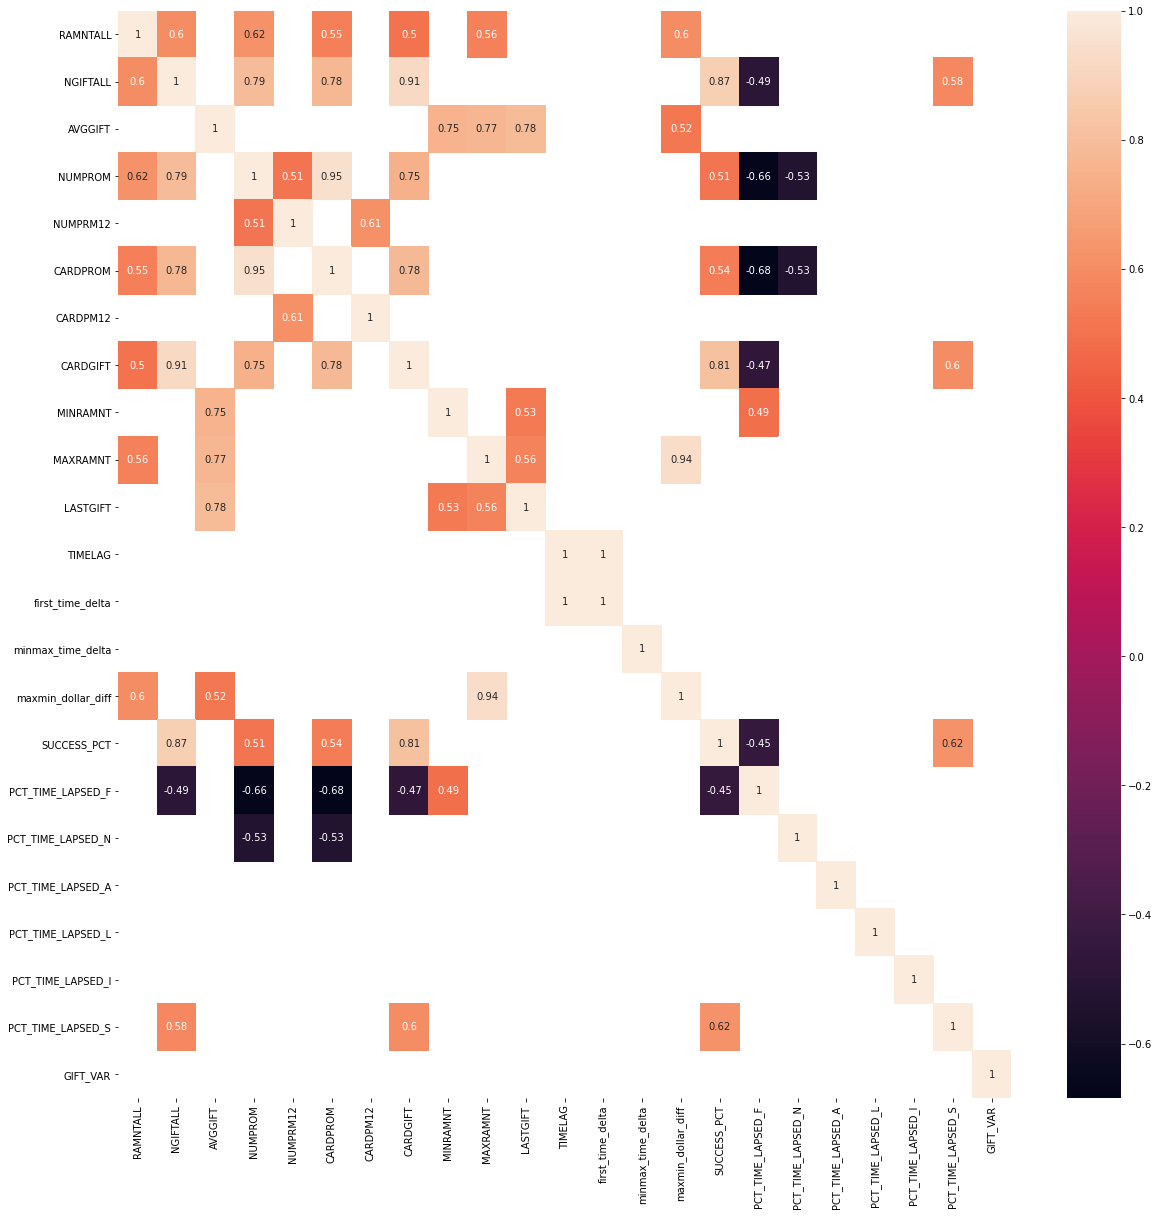

In [32]:
corr = filtered_df.corr()
corr = corr[np.abs(corr) > 0.45]


plt.figure(figsize=(20,20))
sns.heatmap(corr, annot=True)
plt.show()

## Analysing Interests columns

In [33]:
columns_interests= [
    'COLLECT1',
    'VETERANS',
    'BIBLE',
    'CATLG',
    'HOMEE',
    'PETS',
    'CDPLAY',
    'STEREO',
    'PCOWNERS',
    'PHOTO',
    'CRAFTS',
    'FISHER',
    'GARDENIN',
    'BOATS',
    'WALKER',
    'KIDSTUFF',
    'CARDS',
    'PLATES'
]

In [34]:
interests_df = df[columns_interests].copy()
interests_df.head()

,COLLECT1,VETERANS,BIBLE,CATLG,HOMEE,PETS,CDPLAY,STEREO,PCOWNERS,PHOTO,CRAFTS,FISHER,GARDENIN,BOATS,WALKER,KIDSTUFF,CARDS,PLATES
0,,,,,,,,,,,,,,,,,,
1,,,,,,,,,,,,,,,,,,
2,,,,,,,,,,,,,,,,,,
3,,,,,,,,,,,,,,,,,,
4,,,Y,Y,,,,Y,,,Y,,Y,,Y,,Y,


In [35]:
interests_df = interests_df.applymap(lambda val: 1 if val == 'Y' else 0)
interests_df.head()

,COLLECT1,VETERANS,BIBLE,CATLG,HOMEE,PETS,CDPLAY,STEREO,PCOWNERS,PHOTO,CRAFTS,FISHER,GARDENIN,BOATS,WALKER,KIDSTUFF,CARDS,PLATES
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0


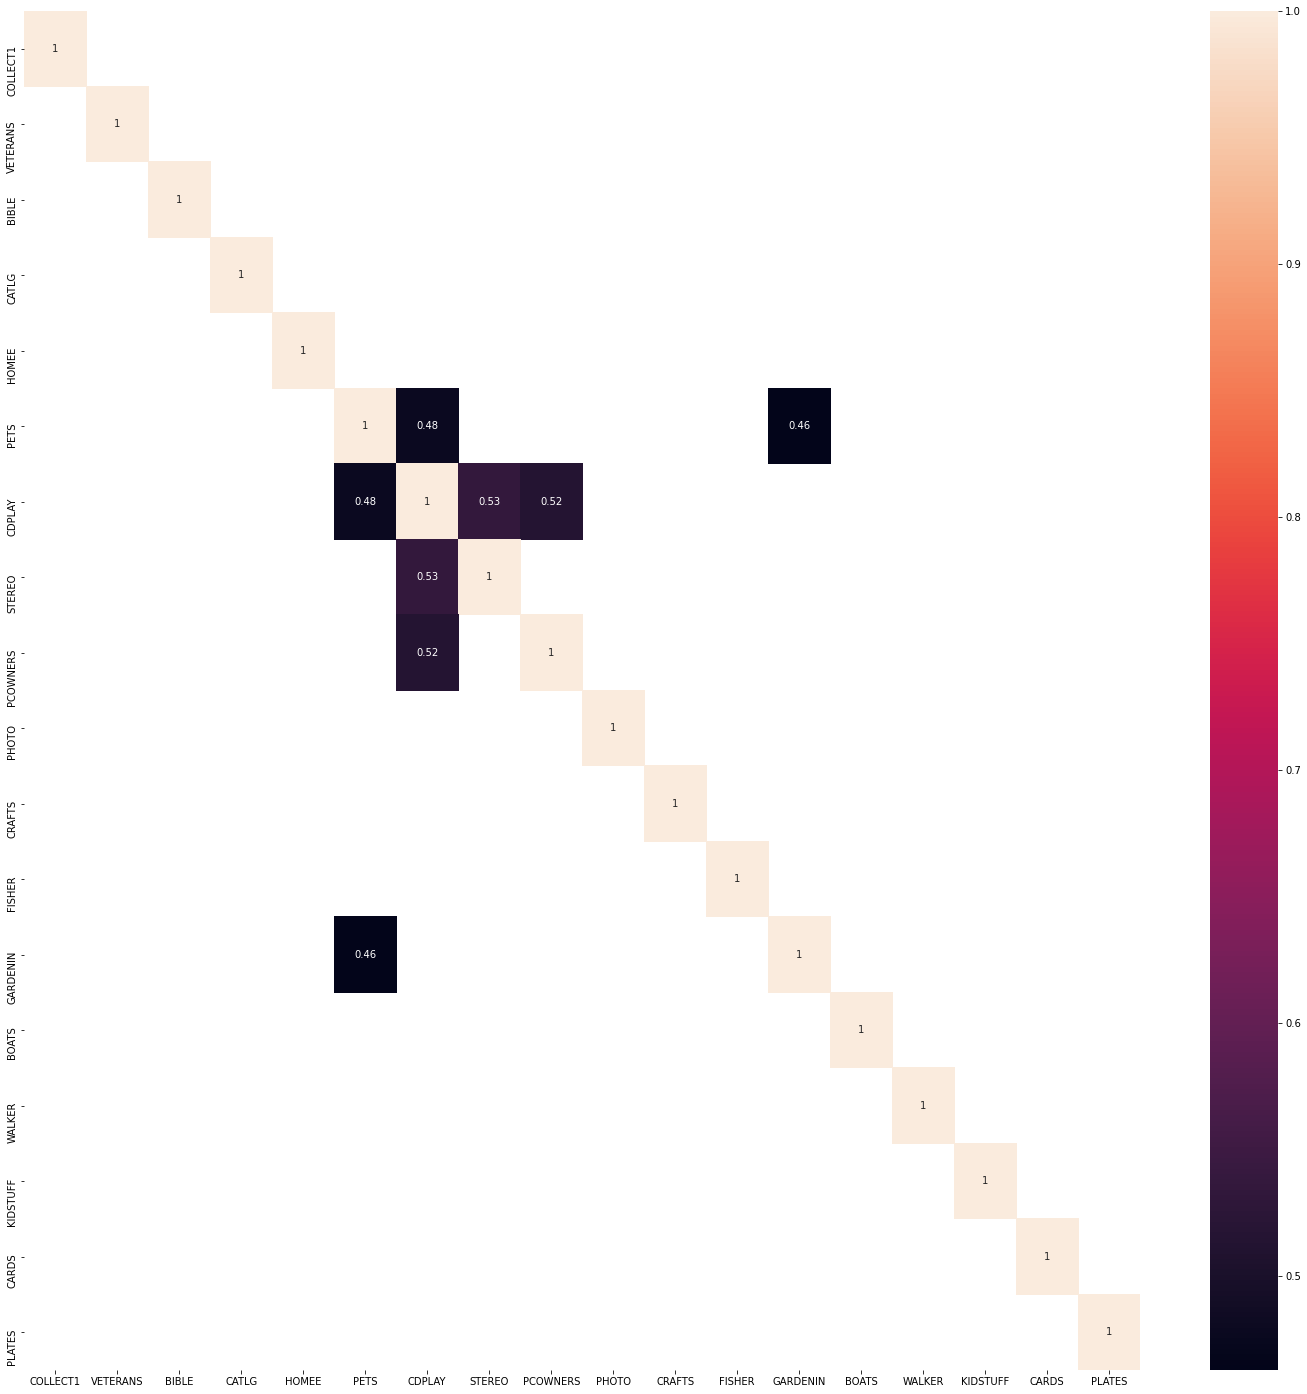

In [36]:
corr = interests_df.corr()
corr = corr[np.abs(corr) > 0.45]

plt.figure(figsize=(25,25))
sns.heatmap(corr, annot=True)
plt.show()

    low correlations, going to ignore for now since there's to many variables

## Adding Country Size

In [37]:
filtered_df['county_size'] = df['GEOCODE2'].replace({'A':1, 'B':2, 'C':3, 'D':4, ' ': np.NaN})

In [38]:
geocode_df = df[['GEOCODE','GEOCODE2']].copy()
geocode_df

,GEOCODE,GEOCODE2
0,,C
1,02,A
2,,C
3,,C
4,,A
...,...,...
95407,,C
95408,,A
95409,,B
95410,04,A


## Analysing wealth columns

In [39]:
filtered_df

,RAMNTALL,NGIFTALL,AVGGIFT,NUMPROM,NUMPRM12,CARDPROM,CARDPM12,CARDGIFT,MINRAMNT,MAXRAMNT,LASTGIFT,TIMELAG,first_time_delta,minmax_time_delta,maxmin_dollar_diff,SUCCESS_PCT,PCT_TIME_LAPSED_F,PCT_TIME_LAPSED_N,PCT_TIME_LAPSED_A,PCT_TIME_LAPSED_L,PCT_TIME_LAPSED_I,PCT_TIME_LAPSED_S,GIFT_VAR,county_size
0,240.0,31,7.741935,74,14,27,6,14,5.0,12.0,10.0,4.0,120.0,-549,7.0,0.418919,0.000000,0.000000,0.000000,0.013514,0.000000,0.297297,0.619048,3.0
1,47.0,3,15.666667,32,13,12,6,1,10.0,25.0,25.0,18.0,547.0,-791,15.0,0.093750,0.031250,0.125000,0.312500,0.062500,0.000000,0.000000,84.500000,1.0
2,202.0,27,7.481481,63,14,26,6,14,2.0,16.0,5.0,12.0,365.0,-243,14.0,0.428571,0.000000,0.000000,0.000000,0.015873,0.000000,0.285714,2.571429,3.0
3,109.0,16,6.812500,66,14,27,6,7,2.0,11.0,10.0,9.0,273.0,-2557,9.0,0.242424,0.000000,0.000000,0.060606,0.015152,0.000000,0.227273,3.904762,3.0
4,254.0,37,6.864865,113,25,43,10,8,3.0,15.0,15.0,14.0,427.0,-822,12.0,0.327434,0.000000,0.000000,0.132743,0.044248,0.017699,0.000000,12.500000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,25.0,1,25.000000,14,12,6,5,0,25.0,25.0,25.0,NaN,NaN,0,0.0,0.071429,0.214286,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,3.0
95408,20.0,1,20.000000,10,8,4,3,0,20.0,20.0,20.0,NaN,NaN,0,0.0,0.100000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,1.0
95409,58.0,7,8.285714,33,17,14,7,4,3.0,10.0,10.0,3.0,92.0,425,7.0,0.212121,0.060606,0.212121,0.030303,0.030303,0.000000,0.121212,6.250000,2.0
95410,498.0,41,12.146341,127,31,36,9,18,5.0,21.0,18.0,4.0,121.0,-2100,16.0,0.322835,0.000000,0.000000,0.039370,0.007874,0.000000,0.133858,4.027778,1.0


In [40]:
len(df)

95412

In [41]:
df['WEALTH1'].count(), df['WEALTH1'].isna().sum()

(50680, 44732)

In [42]:
df['WEALTH2'].count(), df['WEALTH2'].isna().sum()

(51589, 43823)

In [43]:
df.WEALTH1.max(), df.WEALTH1.min()

(9.0, 0.0)

In [44]:
df.WEALTH2.max(), df.WEALTH2.min()

(9.0, 0.0)

In [45]:
wealth_df = df[['WEALTH1','WEALTH2']].copy()

In [46]:
pct_non_NaN = wealth_df.mean(axis=1).count() / wealth_df.shape[0]
print('Percentage of columns with value after merge: %1.2f%%' % (pct_non_NaN *100))

Percentage of columns with value after merge: 77.11%


In [47]:
wealth_df['Merged'] = wealth_df.max(axis=1)
wealth_df.head()

,WEALTH1,WEALTH2,Merged
0,NaN,5.0,5.0
1,9.0,9.0,9.0
2,1.0,1.0,1.0
3,4.0,0.0,4.0
4,2.0,NaN,2.0


In [48]:
wealth_df.isna().sum()

WEALTH1    44732
WEALTH2    43823
Merged     21843
dtype: int64

In [49]:
filtered_df['WEALTH'] = wealth_df.Merged
filtered_df.dropna(subset=['WEALTH'], inplace=True)
del wealth_df

filtered_df.head()

,RAMNTALL,NGIFTALL,AVGGIFT,NUMPROM,NUMPRM12,CARDPROM,CARDPM12,CARDGIFT,MINRAMNT,MAXRAMNT,LASTGIFT,TIMELAG,first_time_delta,minmax_time_delta,maxmin_dollar_diff,SUCCESS_PCT,PCT_TIME_LAPSED_F,PCT_TIME_LAPSED_N,PCT_TIME_LAPSED_A,PCT_TIME_LAPSED_L,PCT_TIME_LAPSED_I,PCT_TIME_LAPSED_S,GIFT_VAR,county_size,WEALTH
0,240.0,31,7.741935,74,14,27,6,14,5.0,12.0,10.0,4.0,120.0,-549,7.0,0.418919,0.00000,0.000,0.000000,0.013514,0.000000,0.297297,0.619048,3.0,5.0
1,47.0,3,15.666667,32,13,12,6,1,10.0,25.0,25.0,18.0,547.0,-791,15.0,0.093750,0.03125,0.125,0.312500,0.062500,0.000000,0.000000,84.500000,1.0,9.0
2,202.0,27,7.481481,63,14,26,6,14,2.0,16.0,5.0,12.0,365.0,-243,14.0,0.428571,0.00000,0.000,0.000000,0.015873,0.000000,0.285714,2.571429,3.0,1.0
3,109.0,16,6.812500,66,14,27,6,7,2.0,11.0,10.0,9.0,273.0,-2557,9.0,0.242424,0.00000,0.000,0.060606,0.015152,0.000000,0.227273,3.904762,3.0,4.0
4,254.0,37,6.864865,113,25,43,10,8,3.0,15.0,15.0,14.0,427.0,-822,12.0,0.327434,0.00000,0.000,0.132743,0.044248,0.017699,0.000000,12.500000,1.0,2.0


## Analysing other columns

In [50]:
other_df = df[['GENDER','INCOME','HOMEOWNR']].copy()
other_df.head()

,GENDER,INCOME,HOMEOWNR
0,F,NaN,
1,M,6.0,H
2,M,3.0,U
3,F,1.0,U
4,F,3.0,H


In [51]:
other_df.HOMEOWNR.replace(['',' '], 'U', inplace=True)
other_df.HOMEOWNR.replace(['U'], 0, inplace=True)
other_df.HOMEOWNR.replace(['H'], 1, inplace=True)

In [52]:
other_df.isna().sum()

GENDER          0
INCOME      21286
HOMEOWNR        0
dtype: int64

In [53]:
other_df.GENDER.replace(['A','C'],'J', inplace=True)
other_df.GENDER.replace(' ','U', inplace=True)
gender_dummies = pd.get_dummies(other_df.GENDER, prefix='GENDER')

In [54]:
other_df.drop(columns='GENDER', inplace=True)
other_df = other_df.join(gender_dummies)

In [55]:
filtered_df = pd.concat([filtered_df, other_df], axis=1)
filtered_df.dropna(subset=['INCOME'], inplace=True)
filtered_df.head()

,RAMNTALL,NGIFTALL,AVGGIFT,NUMPROM,NUMPRM12,CARDPROM,CARDPM12,CARDGIFT,MINRAMNT,MAXRAMNT,LASTGIFT,TIMELAG,first_time_delta,minmax_time_delta,maxmin_dollar_diff,SUCCESS_PCT,PCT_TIME_LAPSED_F,PCT_TIME_LAPSED_N,PCT_TIME_LAPSED_A,PCT_TIME_LAPSED_L,PCT_TIME_LAPSED_I,PCT_TIME_LAPSED_S,GIFT_VAR,county_size,WEALTH,INCOME,HOMEOWNR,GENDER_F,GENDER_J,GENDER_M,GENDER_U
1,47.0,3.0,15.666667,32.0,13.0,12.0,6.0,1.0,10.0,25.0,25.0,18.0,547.0,-791.0,15.0,0.093750,0.03125,0.125,0.312500,0.062500,0.000000,0.000000,84.500000,1.0,9.0,6.0,1,0,0,1,0
2,202.0,27.0,7.481481,63.0,14.0,26.0,6.0,14.0,2.0,16.0,5.0,12.0,365.0,-243.0,14.0,0.428571,0.00000,0.000,0.000000,0.015873,0.000000,0.285714,2.571429,3.0,1.0,3.0,0,0,0,1,0
3,109.0,16.0,6.812500,66.0,14.0,27.0,6.0,7.0,2.0,11.0,10.0,9.0,273.0,-2557.0,9.0,0.242424,0.00000,0.000,0.060606,0.015152,0.000000,0.227273,3.904762,3.0,4.0,1.0,0,1,0,0,0
4,254.0,37.0,6.864865,113.0,25.0,43.0,10.0,8.0,3.0,15.0,15.0,14.0,427.0,-822.0,12.0,0.327434,0.00000,0.000,0.132743,0.044248,0.017699,0.000000,12.500000,1.0,2.0,3.0,1,1,0,0,0
6,107.0,14.0,7.642857,63.0,9.0,26.0,4.0,8.0,3.0,12.0,11.0,4.0,120.0,-2710.0,9.0,0.222222,0.00000,0.000,0.126984,0.015873,0.000000,0.174603,0.500000,4.0,6.0,4.0,1,1,0,0,0


## Analysing Children columns

In [56]:
children_columns = [
    'CHILD03',
    'CHILD07',
    'CHILD12',
    'CHILD18',
    'NUMCHLD'
]

In [57]:
children_df = df[children_columns].copy()
children_df.head()

,CHILD03,CHILD07,CHILD12,CHILD18,NUMCHLD
0,,,,,NaN
1,,,,M,1.0
2,,,,,NaN
3,,,,,NaN
4,,,,,1.0


In [58]:
children_df.replace(' ', 0, inplace=True)
children_df.replace('', 0, inplace=True)
children_df.replace(['M','F','B'], 1, inplace=True)
children_df.fillna(0, inplace=True)

children_df = children_df.astype('int64')
children_df.head()

,CHILD03,CHILD07,CHILD12,CHILD18,NUMCHLD
0,0,0,0,0,0
1,0,0,0,1,1
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,1


In [59]:
children_df['SUM_ageGap_columns'] = children_df[children_columns[:-1]].sum(axis=1)
children_df.drop(columns=children_columns[:-1], inplace=True)

children_df.head()

,NUMCHLD,SUM_ageGap_columns
0,0,0
1,1,1
2,0,0
3,0,0
4,1,0


In [60]:
filtered_df['CHILDREN'] = children_df.max(axis=1)
filtered_df.head()

,RAMNTALL,NGIFTALL,AVGGIFT,NUMPROM,NUMPRM12,CARDPROM,CARDPM12,CARDGIFT,MINRAMNT,MAXRAMNT,LASTGIFT,TIMELAG,first_time_delta,minmax_time_delta,maxmin_dollar_diff,SUCCESS_PCT,PCT_TIME_LAPSED_F,PCT_TIME_LAPSED_N,PCT_TIME_LAPSED_A,PCT_TIME_LAPSED_L,PCT_TIME_LAPSED_I,PCT_TIME_LAPSED_S,GIFT_VAR,county_size,WEALTH,INCOME,HOMEOWNR,GENDER_F,GENDER_J,GENDER_M,GENDER_U,CHILDREN
1,47.0,3.0,15.666667,32.0,13.0,12.0,6.0,1.0,10.0,25.0,25.0,18.0,547.0,-791.0,15.0,0.093750,0.03125,0.125,0.312500,0.062500,0.000000,0.000000,84.500000,1.0,9.0,6.0,1,0,0,1,0,1
2,202.0,27.0,7.481481,63.0,14.0,26.0,6.0,14.0,2.0,16.0,5.0,12.0,365.0,-243.0,14.0,0.428571,0.00000,0.000,0.000000,0.015873,0.000000,0.285714,2.571429,3.0,1.0,3.0,0,0,0,1,0,0
3,109.0,16.0,6.812500,66.0,14.0,27.0,6.0,7.0,2.0,11.0,10.0,9.0,273.0,-2557.0,9.0,0.242424,0.00000,0.000,0.060606,0.015152,0.000000,0.227273,3.904762,3.0,4.0,1.0,0,1,0,0,0,0
4,254.0,37.0,6.864865,113.0,25.0,43.0,10.0,8.0,3.0,15.0,15.0,14.0,427.0,-822.0,12.0,0.327434,0.00000,0.000,0.132743,0.044248,0.017699,0.000000,12.500000,1.0,2.0,3.0,1,1,0,0,0,1
6,107.0,14.0,7.642857,63.0,9.0,26.0,4.0,8.0,3.0,12.0,11.0,4.0,120.0,-2710.0,9.0,0.222222,0.00000,0.000,0.126984,0.015873,0.000000,0.174603,0.500000,4.0,6.0,4.0,1,1,0,0,0,1


In [61]:
filtered_df.shape

(74126, 32)

## Adding Neighborhood Socio Economic Status

In [62]:
int(df['DOMAIN'].mode()[0][1])

2

In [63]:
socio_economic_status = df['DOMAIN'].apply(lambda x : int(x[1]) if x != ' ' else int(df['DOMAIN'].mode()[0][1])) # assign mode in case of NaN
#socio_economic_status = pd.get_dummies(socio_economic_status, prefix='SES_')

socio_economic_status

0        2
1        1
2        2
3        2
4        2
        ..
95407    2
95408    1
95409    3
95410    1
95411    1
Name: DOMAIN, Length: 95412, dtype: int64

In [64]:
rurality = df['DOMAIN'].apply(lambda x : x[0] if x != ' ' else df['DOMAIN'].mode()[0][0])
rurality.replace( {'U':4,
                  'C':3,
                  'S':2, 
                  'T':1,
                  'R':0}, inplace=True)
rurality

0        1
1        2
2        0
3        0
4        2
        ..
95407    3
95408    3
95409    3
95410    3
95411    3
Name: DOMAIN, Length: 95412, dtype: int64

In [65]:
filtered_df['ses'] = socio_economic_status
filtered_df.head()

,RAMNTALL,NGIFTALL,AVGGIFT,NUMPROM,NUMPRM12,CARDPROM,CARDPM12,CARDGIFT,MINRAMNT,MAXRAMNT,LASTGIFT,TIMELAG,first_time_delta,minmax_time_delta,maxmin_dollar_diff,SUCCESS_PCT,PCT_TIME_LAPSED_F,PCT_TIME_LAPSED_N,PCT_TIME_LAPSED_A,PCT_TIME_LAPSED_L,PCT_TIME_LAPSED_I,PCT_TIME_LAPSED_S,GIFT_VAR,county_size,WEALTH,INCOME,HOMEOWNR,GENDER_F,GENDER_J,GENDER_M,GENDER_U,CHILDREN,ses
1,47.0,3.0,15.666667,32.0,13.0,12.0,6.0,1.0,10.0,25.0,25.0,18.0,547.0,-791.0,15.0,0.093750,0.03125,0.125,0.312500,0.062500,0.000000,0.000000,84.500000,1.0,9.0,6.0,1,0,0,1,0,1,1
2,202.0,27.0,7.481481,63.0,14.0,26.0,6.0,14.0,2.0,16.0,5.0,12.0,365.0,-243.0,14.0,0.428571,0.00000,0.000,0.000000,0.015873,0.000000,0.285714,2.571429,3.0,1.0,3.0,0,0,0,1,0,0,2
3,109.0,16.0,6.812500,66.0,14.0,27.0,6.0,7.0,2.0,11.0,10.0,9.0,273.0,-2557.0,9.0,0.242424,0.00000,0.000,0.060606,0.015152,0.000000,0.227273,3.904762,3.0,4.0,1.0,0,1,0,0,0,0,2
4,254.0,37.0,6.864865,113.0,25.0,43.0,10.0,8.0,3.0,15.0,15.0,14.0,427.0,-822.0,12.0,0.327434,0.00000,0.000,0.132743,0.044248,0.017699,0.000000,12.500000,1.0,2.0,3.0,1,1,0,0,0,1,2
6,107.0,14.0,7.642857,63.0,9.0,26.0,4.0,8.0,3.0,12.0,11.0,4.0,120.0,-2710.0,9.0,0.222222,0.00000,0.000,0.126984,0.015873,0.000000,0.174603,0.500000,4.0,6.0,4.0,1,1,0,0,0,1,2


In [66]:
filtered_df['rurality'] = rurality
filtered_df.head()

,RAMNTALL,NGIFTALL,AVGGIFT,NUMPROM,NUMPRM12,CARDPROM,CARDPM12,CARDGIFT,MINRAMNT,MAXRAMNT,LASTGIFT,TIMELAG,first_time_delta,minmax_time_delta,maxmin_dollar_diff,SUCCESS_PCT,PCT_TIME_LAPSED_F,PCT_TIME_LAPSED_N,PCT_TIME_LAPSED_A,PCT_TIME_LAPSED_L,PCT_TIME_LAPSED_I,PCT_TIME_LAPSED_S,GIFT_VAR,county_size,WEALTH,INCOME,HOMEOWNR,GENDER_F,GENDER_J,GENDER_M,GENDER_U,CHILDREN,ses,rurality
1,47.0,3.0,15.666667,32.0,13.0,12.0,6.0,1.0,10.0,25.0,25.0,18.0,547.0,-791.0,15.0,0.093750,0.03125,0.125,0.312500,0.062500,0.000000,0.000000,84.500000,1.0,9.0,6.0,1,0,0,1,0,1,1,2
2,202.0,27.0,7.481481,63.0,14.0,26.0,6.0,14.0,2.0,16.0,5.0,12.0,365.0,-243.0,14.0,0.428571,0.00000,0.000,0.000000,0.015873,0.000000,0.285714,2.571429,3.0,1.0,3.0,0,0,0,1,0,0,2,0
3,109.0,16.0,6.812500,66.0,14.0,27.0,6.0,7.0,2.0,11.0,10.0,9.0,273.0,-2557.0,9.0,0.242424,0.00000,0.000,0.060606,0.015152,0.000000,0.227273,3.904762,3.0,4.0,1.0,0,1,0,0,0,0,2,0
4,254.0,37.0,6.864865,113.0,25.0,43.0,10.0,8.0,3.0,15.0,15.0,14.0,427.0,-822.0,12.0,0.327434,0.00000,0.000,0.132743,0.044248,0.017699,0.000000,12.500000,1.0,2.0,3.0,1,1,0,0,0,1,2,2
6,107.0,14.0,7.642857,63.0,9.0,26.0,4.0,8.0,3.0,12.0,11.0,4.0,120.0,-2710.0,9.0,0.222222,0.00000,0.000,0.126984,0.015873,0.000000,0.174603,0.500000,4.0,6.0,4.0,1,1,0,0,0,1,2,1


In [67]:
filtered_df.dropna(inplace=True)

In [68]:
filtered_df.shape

(57722, 34)

## Adding some more useful columns 

In [69]:
df['MDMAUD_R'].value_counts()

X    95118
C      109
L       70
D       65
I       50
Name: MDMAUD_R, dtype: int64

In [70]:
df['MDMAUD_F'].value_counts()

X    95118
1      187
2       87
5       20
Name: MDMAUD_F, dtype: int64

In [71]:
df['MDMAUD_A'].value_counts()

X    95118
C      249
L       23
M       17
T        5
Name: MDMAUD_A, dtype: int64

In [72]:
df['OSOURCE'].value_counts()

MBC    4539
SYN    3563
AML    3430
BHG    3324
IMP    2986
       ... 
CDN       1
MDA       1
GFT       1
RCS       1
MGR       1
Name: OSOURCE, Length: 896, dtype: int64

In [73]:
df['NOEXCH'].value_counts()

0    61203
0    33882
1      195
1       90
X       35
         7
Name: NOEXCH, dtype: int64

In [74]:
filtered_df['RECINHSE'] = df['RECINHSE'].apply(lambda x : 1 if x == 'X' else 0)
filtered_df

,RAMNTALL,NGIFTALL,AVGGIFT,NUMPROM,NUMPRM12,CARDPROM,CARDPM12,CARDGIFT,MINRAMNT,MAXRAMNT,LASTGIFT,TIMELAG,first_time_delta,minmax_time_delta,maxmin_dollar_diff,SUCCESS_PCT,PCT_TIME_LAPSED_F,PCT_TIME_LAPSED_N,PCT_TIME_LAPSED_A,PCT_TIME_LAPSED_L,PCT_TIME_LAPSED_I,PCT_TIME_LAPSED_S,GIFT_VAR,county_size,WEALTH,INCOME,HOMEOWNR,GENDER_F,GENDER_J,GENDER_M,GENDER_U,CHILDREN,ses,rurality,RECINHSE
1,47.0,3.0,15.666667,32.0,13.0,12.0,6.0,1.0,10.0,25.0,25.0,18.0,547.0,-791.0,15.0,0.093750,0.03125,0.125000,0.312500,0.062500,0.000000,0.000000,84.500000,1.0,9.0,6.0,1,0,0,1,0,1,1,2,0
2,202.0,27.0,7.481481,63.0,14.0,26.0,6.0,14.0,2.0,16.0,5.0,12.0,365.0,-243.0,14.0,0.428571,0.00000,0.000000,0.000000,0.015873,0.000000,0.285714,2.571429,3.0,1.0,3.0,0,0,0,1,0,0,2,0,0
3,109.0,16.0,6.812500,66.0,14.0,27.0,6.0,7.0,2.0,11.0,10.0,9.0,273.0,-2557.0,9.0,0.242424,0.00000,0.000000,0.060606,0.015152,0.000000,0.227273,3.904762,3.0,4.0,1.0,0,1,0,0,0,0,2,0,0
4,254.0,37.0,6.864865,113.0,25.0,43.0,10.0,8.0,3.0,15.0,15.0,14.0,427.0,-822.0,12.0,0.327434,0.00000,0.000000,0.132743,0.044248,0.017699,0.000000,12.500000,1.0,2.0,3.0,1,1,0,0,0,1,2,2,1
6,107.0,14.0,7.642857,63.0,9.0,26.0,4.0,8.0,3.0,12.0,11.0,4.0,120.0,-2710.0,9.0,0.222222,0.00000,0.000000,0.126984,0.015873,0.000000,0.174603,0.500000,4.0,6.0,4.0,1,1,0,0,0,1,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95403,139.0,12.0,11.583333,51.0,8.0,22.0,4.0,6.0,3.0,20.0,20.0,10.0,306.0,-1371.0,17.0,0.235294,0.00000,0.000000,0.372549,0.039216,0.000000,0.000000,1.333333,4.0,5.0,4.0,1,1,0,0,0,0,2,0,0
95404,59.0,10.0,5.900000,38.0,12.0,17.0,6.0,8.0,3.0,11.0,8.0,3.0,92.0,-577.0,8.0,0.263158,0.00000,0.131579,0.000000,0.026316,0.000000,0.421053,5.142857,4.0,3.0,1.0,1,1,0,0,0,1,2,0,0
95406,81.0,24.0,3.375000,59.0,12.0,23.0,5.0,12.0,2.0,9.0,2.0,3.0,92.0,1798.0,7.0,0.406780,0.00000,0.000000,0.000000,0.016949,0.000000,0.288136,1.300000,3.0,6.0,6.0,1,1,0,0,0,0,2,2,0
95410,498.0,41.0,12.146341,127.0,31.0,36.0,9.0,18.0,5.0,21.0,18.0,4.0,121.0,-2100.0,16.0,0.322835,0.00000,0.000000,0.039370,0.007874,0.000000,0.133858,4.027778,1.0,7.0,7.0,1,1,0,0,0,0,1,3,1


In [75]:
filtered_df['RECP3'] = df['RECP3'].apply(lambda x : 1 if x == 'X' else 0)

In [76]:
filtered_df['RECPGVG'] = df['RECPGVG'].apply(lambda x : 1 if x == 'X' else 0)

In [77]:
filtered_df['RECSWEEP'] = df['RECSWEEP'].apply(lambda x : 1 if x == 'X' else 0)

In [78]:
filtered_df['HIT'] = df['HIT']

In [79]:
filtered_df['MAJOR'] = df['MAJOR'].apply(lambda x : 1 if x == 'X' else 0)

In [80]:
df[['GEOCODE','GEOCODE2']].isna()

df[((df['GEOCODE'].isna() == False) | (df['GEOCODE2'].isna() == False))]

# Later on, we can reduce number of NaN by correcting this geocode.

,Unnamed: 0,ODATEDW,OSOURCE,TCODE,STATE,ZIP,MAILCODE,PVASTATE,DOB,NOEXCH,RECINHSE,RECP3,RECPGVG,RECSWEEP,MDMAUD,DOMAIN,HOMEOWNR,CHILD03,CHILD07,CHILD12,CHILD18,NUMCHLD,INCOME,GENDER,WEALTH1,HIT,MBCRAFT,MBGARDEN,MBBOOKS,MBCOLECT,MAGFAML,MAGFEM,MAGMALE,PUBGARDN,PUBCULIN,PUBHLTH,PUBDOITY,PUBNEWFN,PUBPHOTO,PUBOPP,DATASRCE,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,STATEGOV,FEDGOV,SOLP3,SOLIH,MAJOR,WEALTH2,GEOCODE,COLLECT1,VETERANS,BIBLE,CATLG,HOMEE,PETS,CDPLAY,STEREO,PCOWNERS,PHOTO,CRAFTS,FISHER,GARDENIN,BOATS,WALKER,KIDSTUFF,CARDS,PLATES,LIFESRC,PEPSTRFL,POP901,POP902,POP903,POP90C1,POP90C2,POP90C3,POP90C4,POP90C5,ETH1,ETH2,ETH3,ETH4,ETH5,ETH6,ETH7,ETH8,ETH9,ETH10,ETH11,ETH12,ETH13,ETH14,ETH15,ETH16,AGE901,AGE902,AGE903,AGE904,AGE905,AGE906,AGE907,CHIL1,CHIL2,CHIL3,AGEC1,AGEC2,AGEC3,AGEC4,AGEC5,AGEC6,AGEC7,CHILC1,CHILC2,CHILC3,CHILC4,CHILC5,HHAGE1,HHAGE2,HHAGE3,HHN1,HHN2,HHN3,HHN4,HHN5,HHN6,MARR1,MARR2,MARR3,MARR4,HHP1,HHP2,DW1,DW2,DW3,DW4,DW5,DW6,DW7,DW8,DW9,HV1,HV2,HV3,HV4,HU1,HU2,HU3,HU4,HU5,HHD1,HHD2,HHD3,HHD4,HHD5,HHD6,HHD7,HHD8,HHD9,HHD10,HHD11,HHD12,ETHC1,ETHC2,ETHC3,ETHC4,ETHC5,ETHC6,HVP1,HVP2,HVP3,HVP4,HVP5,HVP6,HUR1,HUR2,RHP1,RHP2,RHP3,RHP4,HUPA1,HUPA2,HUPA3,HUPA4,HUPA5,HUPA6,HUPA7,RP1,RP2,RP3,RP4,MSA,ADI,DMA,IC1,IC2,IC3,IC4,IC5,IC6,IC7,IC8,IC9,IC10,IC11,IC12,IC13,IC14,IC15,IC16,IC17,IC18,IC19,IC20,IC21,IC22,IC23,HHAS1,HHAS2,HHAS3,HHAS4,MC1,MC2,MC3,TPE1,TPE2,TPE3,TPE4,TPE5,TPE6,TPE7,TPE8,TPE9,PEC1,PEC2,TPE10,TPE11,TPE12,TPE13,LFC1,LFC2,LFC3,LFC4,LFC5,LFC6,LFC7,LFC8,LFC9,LFC10,OCC1,OCC2,OCC3,OCC4,OCC5,OCC6,OCC7,OCC8,OCC9,OCC10,OCC11,OCC12,OCC13,EIC1,EIC2,EIC3,EIC4,EIC5,EIC6,EIC7,EIC8,EIC9,EIC10,EIC11,EIC12,EIC13,EIC14,EIC15,EIC16,OEDC1,OEDC2,OEDC3,OEDC4,OEDC5,OEDC6,OEDC7,EC1,EC2,EC3,EC4,EC5,EC6,EC7,EC8,SEC1,SEC2,SEC3,SEC4,SEC5,AFC1,AFC2,AFC3,AFC4,AFC5,AFC6,VC1,VC2,VC3,VC4,ANC1,ANC2,ANC3,ANC4,ANC5,ANC6,ANC7,ANC8,ANC9,ANC10,ANC11,ANC12,ANC13,ANC14,ANC15,POBC1,POBC2,LSC1,LSC2,LSC3,LSC4,VOC1,VOC2,VOC3,HC1,HC2,HC3,HC4,HC5,HC6,HC7,HC8,HC9,HC10,HC11,HC12,HC13,HC14,HC15,HC16,HC17,HC18,HC19,HC20,HC21,MHUC1,MHUC2,AC1,AC2,ADATE_2,ADATE_3,ADATE_4,ADATE_5,ADATE_6,ADATE_7,ADATE_8,ADATE_9,ADATE_10,ADATE_11,ADATE_12,ADATE_13,ADATE_14,ADATE_15,ADATE_16,ADATE_17,ADATE_18,ADATE_19,ADATE_20,ADATE_21,ADATE_22,ADATE_23,ADATE_24,RFA_2,RFA_3,RFA_4,RFA_5,RFA_6,RFA_7,RFA_8,RFA_9,RFA_10,RFA_11,RFA_12,RFA_13,RFA_14,RFA_15,RFA_16,RFA_17,RFA_18,RFA_19,RFA_20,RFA_21,RFA_22,RFA_23,RFA_24,CARDPROM,MAXADATE,NUMPROM,CARDPM12,NUMPRM12,RDATE_3,RDATE_4,RDATE_5,RDATE_6,RDATE_7,RDATE_8,RDATE_9,RDATE_10,RDATE_11,RDATE_12,RDATE_13,RDATE_14,RDATE_15,RDATE_16,RDATE_17,RDATE_18,RDATE_19,RDATE_20,RDATE_21,RDATE_22,RDATE_23,RDATE_24,RAMNT_3,RAMNT_4,RAMNT_5,RAMNT_6,RAMNT_7,RAMNT_8,RAMNT_9,RAMNT_10,RAMNT_11,RAMNT_12,RAMNT_13,RAMNT_14,RAMNT_15,RAMNT_16,RAMNT_17,RAMNT_18,RAMNT_19,RAMNT_20,RAMNT_21,RAMNT_22,RAMNT_23,RAMNT_24,RAMNTALL,NGIFTALL,CARDGIFT,MINRAMNT,MINRDATE,MAXRAMNT,MAXRDATE,LASTGIFT,LASTDATE,FISTDATE,NEXTDATE,TIMELAG,AVGGIFT,CONTROLN,HPHONE_D,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,GEOCODE2
0,0,2009-01-01,GRI,0,IL,61081,,,1957-12-01,0,,,,,XXXX,T2,,,,,,NaN,NaN,F,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,0,39,34,18,10,2,1,,,,5.0,,,,,,,,,,,,,,,,,,,,,X,992,264,332,0,35,65,47,53,92,1,0,0,11,0,0,0,0,0,0,0,11,0,0,0,39,48,51,40,50,54,25,31,42,27,11,14,18,17,13,11,15,12,11,34,25,18,26,10,23,18,33,49,28,12,4,61,7,12,19,198,276,97,95,2,2,0,0,7,7,0,479,635,3,2,86,14,96,4,7,38,80,70,32,84,16,6,2,5,9,15,3,17,50,25,0,0,0,2,7,13,27,47,0,1,61,58,61,15,4,2,0,0,14,1,0,0,2,5,17,73,0.0,177.0,682.0,307,318,349,378,12883,13,23,23,23,15,1,0,0,1,4,25,24,26,17,2,0,0,2,28,4,51,1,46,54,3,88,8,0,0,0,0,0,0,4,1,13,14,16,2,45,56,64,50,64,44,62,53,99,0,0,9,3,8,13,9,0,3,9,3,15,19,5,4,3,0,3,41,1,0,7,13,6,5,0,4,9,4,1,3,10,2,1,7,78,2,0,120,16,10,39,21,8,4,3,5,20,3,19,4,0,0,0,18,39,0,34,23,18,16,1,4,0,23,0,0,5,1,0,0,0,0,0,2,0,3,74,88,8,0,4,96,77,19,13,31,5,14,14,31,54,46,0,0,90,0,10,0,0,0,33,65,40,99,99,6,2,10,7,2017-06-01,2016-06-01,2016-04-01,2016-04-01,2016-03-01,

In [81]:
filtered_df

,RAMNTALL,NGIFTALL,AVGGIFT,NUMPROM,NUMPRM12,CARDPROM,CARDPM12,CARDGIFT,MINRAMNT,MAXRAMNT,LASTGIFT,TIMELAG,first_time_delta,minmax_time_delta,maxmin_dollar_diff,SUCCESS_PCT,PCT_TIME_LAPSED_F,PCT_TIME_LAPSED_N,PCT_TIME_LAPSED_A,PCT_TIME_LAPSED_L,PCT_TIME_LAPSED_I,PCT_TIME_LAPSED_S,GIFT_VAR,county_size,WEALTH,INCOME,HOMEOWNR,GENDER_F,GENDER_J,GENDER_M,GENDER_U,CHILDREN,ses,rurality,RECINHSE,RECP3,RECPGVG,RECSWEEP,HIT,MAJOR
1,47.0,3.0,15.666667,32.0,13.0,12.0,6.0,1.0,10.0,25.0,25.0,18.0,547.0,-791.0,15.0,0.093750,0.03125,0.125000,0.312500,0.062500,0.000000,0.000000,84.500000,1.0,9.0,6.0,1,0,0,1,0,1,1,2,0,0,0,0,16,0
2,202.0,27.0,7.481481,63.0,14.0,26.0,6.0,14.0,2.0,16.0,5.0,12.0,365.0,-243.0,14.0,0.428571,0.00000,0.000000,0.000000,0.015873,0.000000,0.285714,2.571429,3.0,1.0,3.0,0,0,0,1,0,0,2,0,0,0,0,0,2,0
3,109.0,16.0,6.812500,66.0,14.0,27.0,6.0,7.0,2.0,11.0,10.0,9.0,273.0,-2557.0,9.0,0.242424,0.00000,0.000000,0.060606,0.015152,0.000000,0.227273,3.904762,3.0,4.0,1.0,0,1,0,0,0,0,2,0,0,0,0,0,2,0
4,254.0,37.0,6.864865,113.0,25.0,43.0,10.0,8.0,3.0,15.0,15.0,14.0,427.0,-822.0,12.0,0.327434,0.00000,0.000000,0.132743,0.044248,0.017699,0.000000,12.500000,1.0,2.0,3.0,1,1,0,0,0,1,2,2,1,1,0,0,60,0
6,107.0,14.0,7.642857,63.0,9.0,26.0,4.0,8.0,3.0,12.0,11.0,4.0,120.0,-2710.0,9.0,0.222222,0.00000,0.000000,0.126984,0.015873,0.000000,0.174603,0.500000,4.0,6.0,4.0,1,1,0,0,0,1,2,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95403,139.0,12.0,11.583333,51.0,8.0,22.0,4.0,6.0,3.0,20.0,20.0,10.0,306.0,-1371.0,17.0,0.235294,0.00000,0.000000,0.372549,0.039216,0.000000,0.000000,1.333333,4.0,5.0,4.0,1,1,0,0,0,0,2,0,0,0,0,0,0,0
95404,59.0,10.0,5.900000,38.0,12.0,17.0,6.0,8.0,3.0,11.0,8.0,3.0,92.0,-577.0,8.0,0.263158,0.00000,0.131579,0.000000,0.026316,0.000000,0.421053,5.142857,4.0,3.0,1.0,1,1,0,0,0,1,2,0,0,0,0,0,0,0
95406,81.0,24.0,3.375000,59.0,12.0,23.0,5.0,12.0,2.0,9.0,2.0,3.0,92.0,1798.0,7.0,0.406780,0.00000,0.000000,0.000000,0.016949,0.000000,0.288136,1.300000,3.0,6.0,6.0,1,1,0,0,0,0,2,2,0,0,0,0,10,0
95410,498.0,41.0,12.146341,127.0,31.0,36.0,9.0,18.0,5.0,21.0,18.0,4.0,121.0,-2100.0,16.0,0.322835,0.00000,0.000000,0.039370,0.007874,0.000000,0.133858,4.027778,1.0,7.0,7.0,1,1,0,0,0,0,1,3,1,0,0,0,0,0


## Outlier Removal

In [82]:
def get_tukey_outliers(values, MULTIPLICATION_FACTOR = 1.5):
    Q1 = np.percentile(values, 25)
    Q3 = np.percentile(values, 75)

    IQR = Q3 - Q1
    left_limit = Q1 - (MULTIPLICATION_FACTOR * IQR)
    right_limit = Q3 + (MULTIPLICATION_FACTOR * IQR)

    outliers_idx = list(values.index[(values < left_limit) | (values > right_limit)])
    outliers_val = list(values[outliers_idx])

    print('Q1: ', Q1)
    print('Q3: ', Q3)
    print('IQR: ', IQR)
    print('left_limit: ', left_limit)
    print('right_limit: ', right_limit)
    return outliers_idx, outliers_val

### RAMNTALL

In [83]:
RAMNTALL_outliers_idx, RAMNTALL_outliers_val = get_tukey_outliers(filtered_df.RAMNTALL, MULTIPLICATION_FACTOR=7)

print("Nr. RAMNTALL to drop = ", len(RAMNTALL_outliers_val))
print("% of rows to be dropped= ", len(RAMNTALL_outliers_idx) / filtered_df.shape[0])

Q1:  57.0
Q3:  147.0
IQR:  90.0
left_limit:  -573.0
right_limit:  777.0
Nr. RAMNTALL to drop =  195
% of rows to be dropped=  0.0033782613215065315


In [84]:
filtered_df.drop(index=RAMNTALL_outliers_idx, inplace=True)

### AVGGIFT

In [85]:
AVGGIFT_outliers_idx, AVGGIFT_outliers_val = get_tukey_outliers(filtered_df.AVGGIFT, MULTIPLICATION_FACTOR=7)

print("Nr. AVGGIFT to drop = ", len(AVGGIFT_outliers_val))
print("% of rows to be dropped= ", len(AVGGIFT_outliers_idx) / filtered_df.shape[0])

Q1:  8.0
Q3:  14.363636364000001
IQR:  6.363636364000001
left_limit:  -36.54545454800001
right_limit:  58.90909091200001
Nr. AVGGIFT to drop =  132
% of rows to be dropped=  0.0022945747214351522


In [86]:
filtered_df.drop(index=AVGGIFT_outliers_idx, inplace=True)

### TIMELAG

In [87]:
TIMELAG_outliers_idx, TIMELAG_outliers_val = get_tukey_outliers(filtered_df.TIMELAG, MULTIPLICATION_FACTOR=7)

print("Nr. TIMELAG to drop = ", len(TIMELAG_outliers_val))
print("% of rows to be dropped= ", len(TIMELAG_outliers_idx) / filtered_df.shape[0])

Q1:  4.0
Q3:  11.0
IQR:  7.0
left_limit:  -45.0
right_limit:  60.0
Nr. TIMELAG to drop =  4
% of rows to be dropped=  6.96924819235125e-05


In [88]:
filtered_df.drop(index=TIMELAG_outliers_idx, inplace=True)

### GIFT_VAR

In [89]:
GIFT_VAR_outliers_idx, GIFT_VAR_outliers_val = get_tukey_outliers(filtered_df.GIFT_VAR, MULTIPLICATION_FACTOR=15)

print("Nr. GIFT_VAR to drop = ", len(GIFT_VAR_outliers_val))
print("% of rows to be dropped= ", len(GIFT_VAR_outliers_idx) / filtered_df.shape[0])

Q1:  0.0
Q3:  12.5
IQR:  12.5
left_limit:  -187.5
right_limit:  200.0
Nr. GIFT_VAR to drop =  660
% of rows to be dropped=  0.011500060985171891


In [90]:
filtered_df.drop(index=GIFT_VAR_outliers_idx, inplace=True)

### maxmin_dollar_dif

In [91]:
maxmin_dollar_diff_outliers_idx, maxmin_dollar_diff_outliers_val = get_tukey_outliers(filtered_df.maxmin_dollar_diff, MULTIPLICATION_FACTOR=10)

print("Nr. maxmin_dollar_dif to drop = ", len(maxmin_dollar_diff_outliers_val))
print("% of rows to be dropped= ", len(maxmin_dollar_diff_outliers_idx) / filtered_df.shape[0])

Q1:  7.0
Q3:  15.0
IQR:  8.0
left_limit:  -73.0
right_limit:  95.0
Nr. maxmin_dollar_dif to drop =  46
% of rows to be dropped=  0.0008108441592779962


In [92]:
filtered_df.drop(index=maxmin_dollar_diff_outliers_idx, inplace=True)

## Normalizing data

In [93]:
from sklearn.preprocessing import StandardScaler

In [94]:
# https://stats.stackexchange.com/questions/164917/should-data-be-centeredscaled-before-applying-t-sne 
scaler = StandardScaler()

scaled_filtered_df = pd.DataFrame(scaler.fit_transform(filtered_df), columns = filtered_df.columns)
scaled_filtered_df

,RAMNTALL,NGIFTALL,AVGGIFT,NUMPROM,NUMPRM12,CARDPROM,CARDPM12,CARDGIFT,MINRAMNT,MAXRAMNT,LASTGIFT,TIMELAG,first_time_delta,minmax_time_delta,maxmin_dollar_diff,SUCCESS_PCT,PCT_TIME_LAPSED_F,PCT_TIME_LAPSED_N,PCT_TIME_LAPSED_A,PCT_TIME_LAPSED_L,PCT_TIME_LAPSED_I,PCT_TIME_LAPSED_S,GIFT_VAR,county_size,WEALTH,INCOME,HOMEOWNR,GENDER_F,GENDER_J,GENDER_M,GENDER_U,CHILDREN,ses,rurality,RECINHSE,RECP3,RECPGVG,RECSWEEP,HIT,MAJOR
0,-0.785408,-0.977794,0.674433,-1.056293,-0.052986,-1.191830,0.416502,-1.075945,0.884241,0.691584,1.036760,1.557883,1.554664,0.064174,0.287016,-1.060719,0.167049,0.819701,0.830304,0.392957,-0.215598,-0.641261,2.914323,-1.064664,1.352407,1.156689,0.629075,-1.082592,-0.068143,1.145826,-0.154886,1.059377,-1.237361,0.153766,-0.298866,-0.152602,-0.024856,-0.138574,0.969771,-0.023392
1,1.009895,1.881465,-0.742657,0.475934,0.167487,0.667072,0.416502,1.775661,-0.878773,-0.273281,-1.268228,0.605372,0.605570,0.577058,0.169314,2.476118,-0.406514,-0.529155,-1.384122,-0.726035,-0.215598,1.901191,-0.377915,0.782187,-1.558164,-0.462807,-1.589636,-1.082592,-0.068143,1.145826,-0.154886,-0.412023,0.141092,-1.364348,-0.298866,-0.152602,-0.024856,-0.138574,-0.272165,-0.023392
2,-0.067287,0.570971,-0.858476,0.624214,0.167487,0.799851,0.416502,0.240181,-0.878773,-0.809318,-0.691981,0.129116,0.125808,-1.588663,-0.419194,0.509779,-0.406514,-0.529155,-0.954658,-0.743350,-0.215598,1.381144,-0.324336,0.782187,-0.466700,-1.542471,-1.589636,0.923709,-0.068143,-0.872733,-0.154886,-0.412023,0.141092,-1.364348,-0.298866,-0.152602,-0.024856,-0.138574,-0.272165,-0.023392
3,1.612191,3.072823,-0.849411,2.947268,2.592689,2.924310,4.062465,0.459535,-0.658396,-0.380488,-0.115734,0.922876,0.928888,0.035160,-0.066089,1.407763,-0.406514,-0.529155,-0.443481,-0.045074,1.148497,-0.641261,0.021057,-1.064664,-1.194343,-0.462807,0.629075,0.923709,-0.068143,-0.872733,-0.154886,1.059377,0.141092,0.153766,3.345978,6.553004,-0.024856,-0.138574,4.873001,-0.023392
4,-0.090452,0.332700,-0.714718,0.475934,-0.934877,0.667072,-1.406479,0.459535,-0.658396,-0.702110,-0.576732,-0.664644,-0.672057,-1.731858,-0.419194,0.296378,-0.406514,-0.529155,-0.484292,-0.726035,-0.215598,0.912460,-0.461154,1.705613,0.260942,0.077025,0.629075,0.923709,-0.068143,-0.872733,-0.154886,1.059377,0.141092,-0.605291,-0.298866,-0.152602,-0.024856,-0.138574,-0.449585,-0.023392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56680,-0.993895,-0.977794,-0.364338,-1.155146,-0.714404,-1.324608,-1.406479,-1.295299,-0.217642,-0.380488,-0.115734,0.287868,0.287467,0.149343,-0.301492,-0.994698,0.205286,1.629014,1.214138,-0.307008,-0.215598,-0.641261,0.242071,-0.141238,0.988585,1.156689,0.629075,0.923709,-0.068143,-0.872733,-0.154886,-0.412023,-1.237361,0.912824,-0.298866,-0.152602,-0.024856,-0.138574,-0.272165,-0.023392
56681,0.280191,0.094428,-0.032509,-0.117186,-1.155350,0.135957,-1.406479,0.020827,-0.658396,0.155548,0.460513,0.287868,0.297897,-0.478660,0.522419,0.434461,-0.406514,-0.529155,1.255821,-0.165839,-0.215598,-0.641261,-0.427667,1.705613,-0.102879,0.077025,0.629075,0.923709,-0.068143,-0.872733,-0.154886,-0.412023,0.141092,-1.364348,-0.298866,-0.152602,-0.024856,-0.138574,-0.449585,-0.023392
56682,-0.646417,-0.143844,-1.016456,-0.759733,-0.273459,-0.527936,0.416502,0.459535,-0.658396,-0.809318,-0.922480,-0.823396,-0.818071,0.264461,-0.536896,0.728796,-0.406514,0.890693,-1.384122,-0.475421,-0.215598,3.105510,-0.274584,1.705613,-0.830522,-1.542471,0.629075,0.923709,-0.068143,-0.872733,-0.154886,1.059377,0.141092,-1.364348,-0.298866,-0.152602,-0.024856,-0.138574,-0.449585,-0.023392
56683,-0.391600,1.524058,-1.453606,0.278227,-0.273459,0.268736,-0.494988,1.336952,-0.878773,-1.023732,-1.613976,-0.823396,-0.818071,2.487273,-0.654597,2.245923,-0.406514,-0.529155,-1.384122,-0.700209,-0.215598,1.922737,-0.429006,0.782187,0.260942,1.156689,0.629075,0.923709,-0.068143,-0.872733,-0.154886,-0.

In [95]:
filtered_df.dropna(inplace=True)

In [96]:
filtered_df.shape

(56685, 40)

## Correlation check

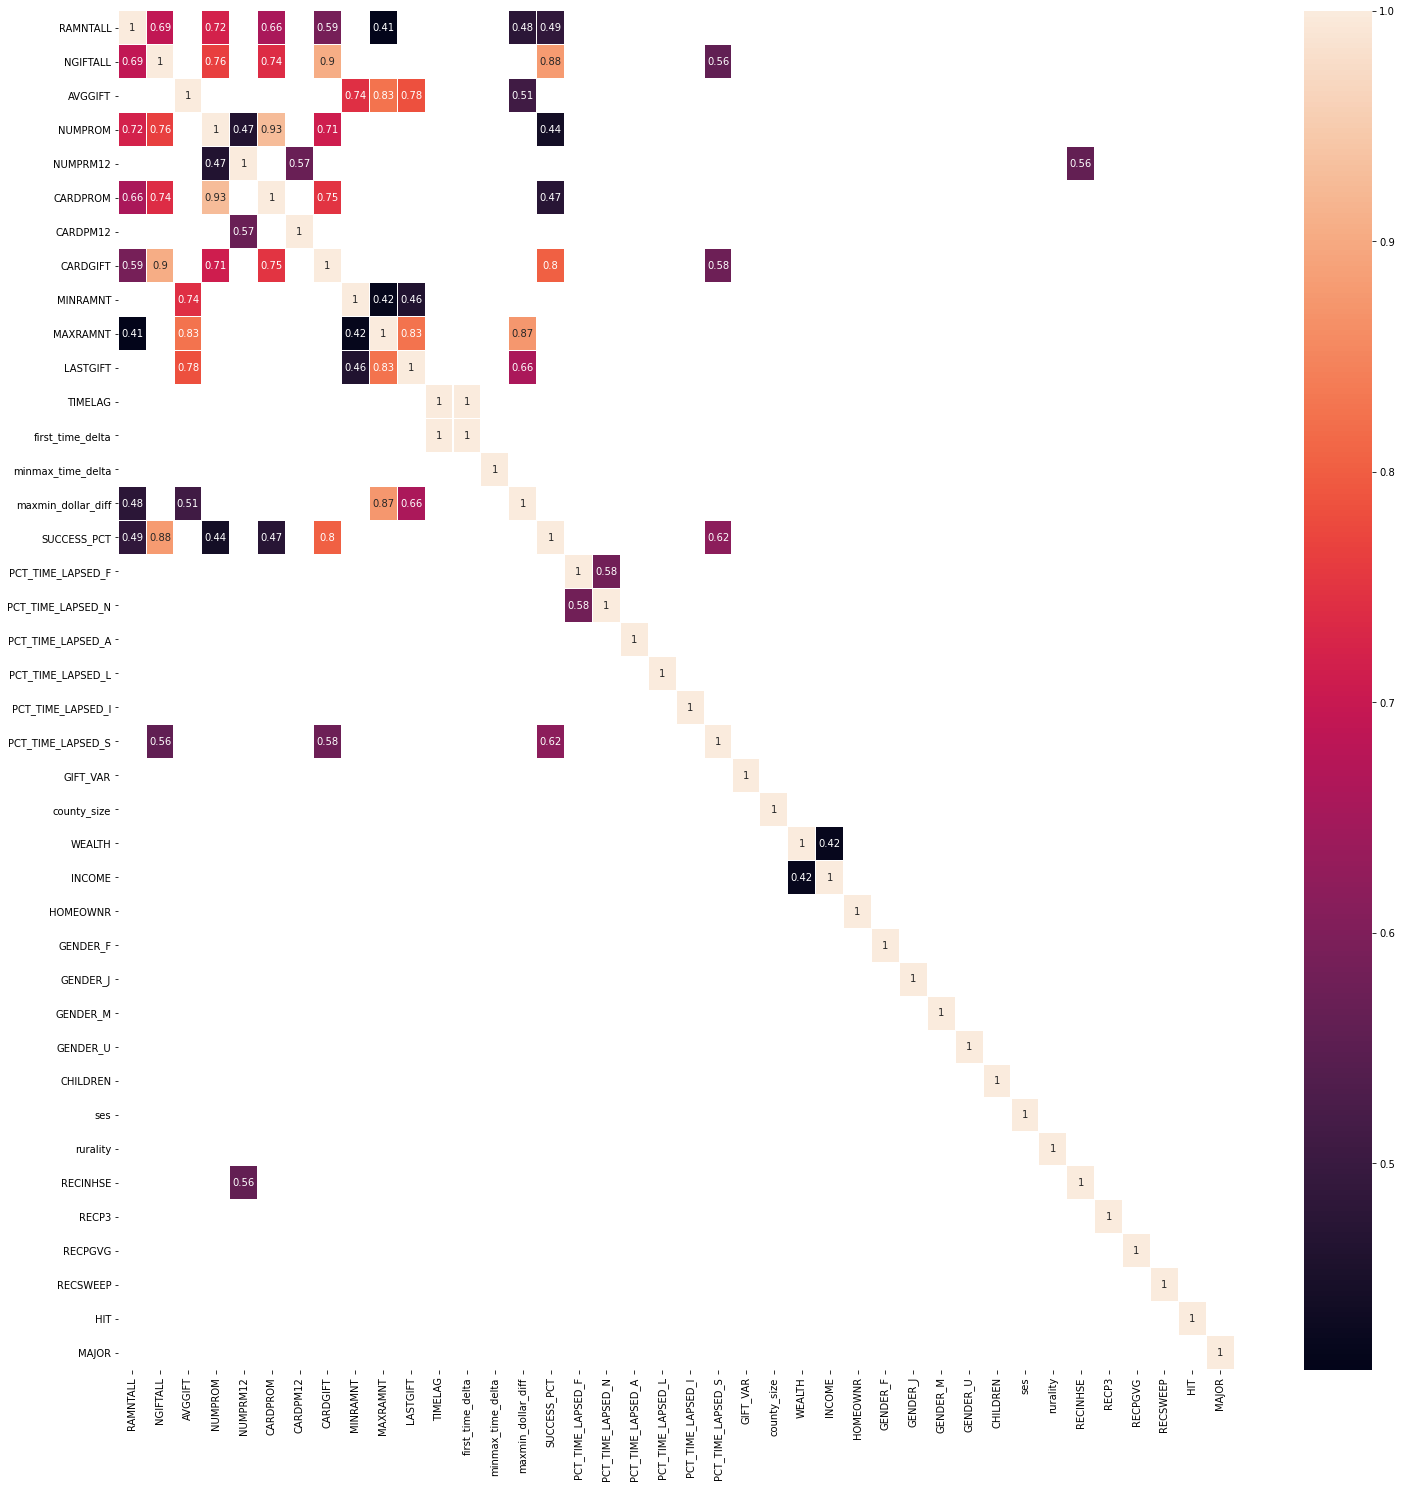

In [97]:
corr = filtered_df.corr()
corr = corr[corr > 0.4]

plt.figure(figsize=(25,25))
sns.heatmap(corr, annot=True, linewidths=0.1)
plt.show()

### Dropping some columns with high correlation

In [98]:
filtered_df.drop(columns=['NGIFTALL','CARDGIFT','LASTGIFT','MAXRAMNT','CARDPROM', 'minmax_time_delta', 'first_time_delta', 'county_size'], inplace=True)

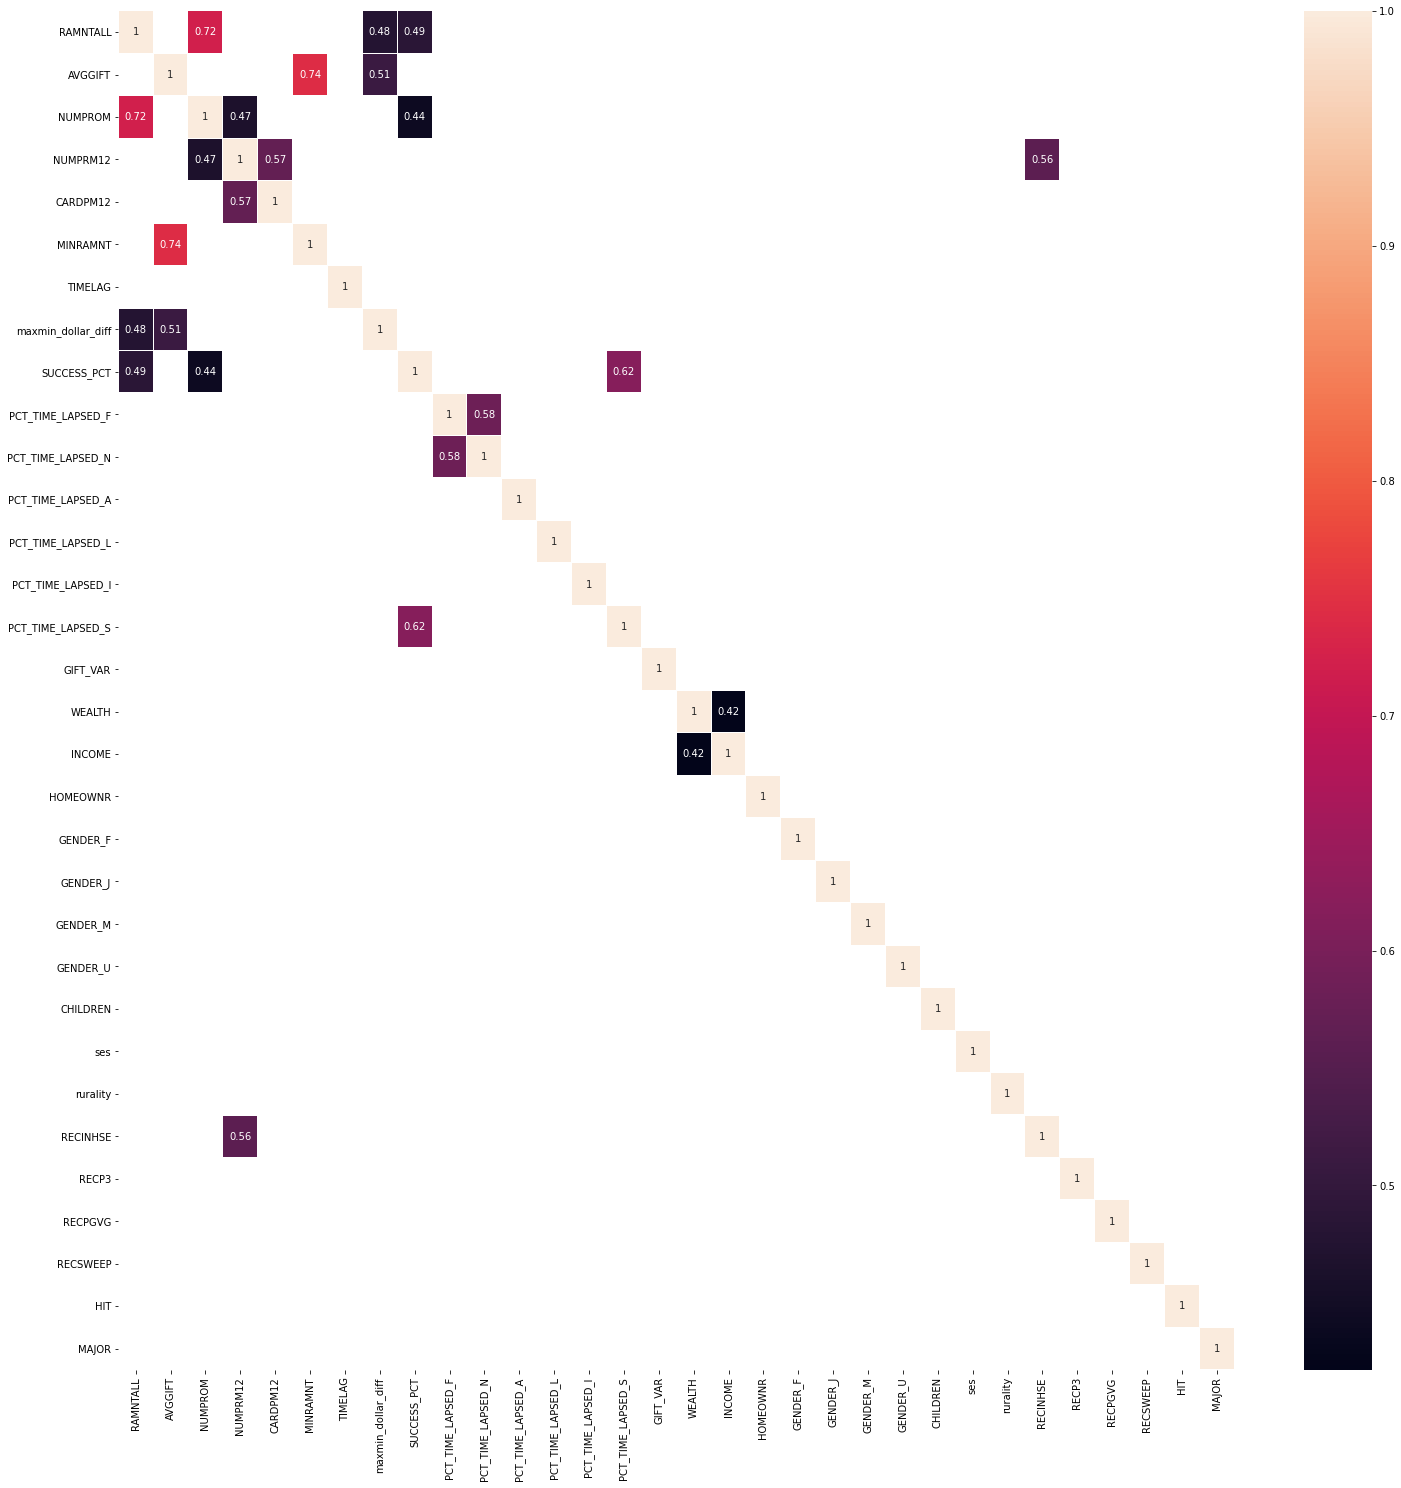

In [99]:
corr = filtered_df.corr()
corr = corr[corr > 0.4]

plt.figure(figsize=(25,25))
sns.heatmap(corr, annot=True, linewidths=0.1)
plt.show()

In [100]:
filtered_df.shape

(56685, 32)

    overall looking ok

# Clustering

In [101]:
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import Birch

In [102]:
inertia = []
k_range = range(1,15)

In [103]:
for k in k_range:
    k_means = KMeans(n_clusters=k)
    k_means.fit(filtered_df)
    inertia.append(k_means.inertia_)

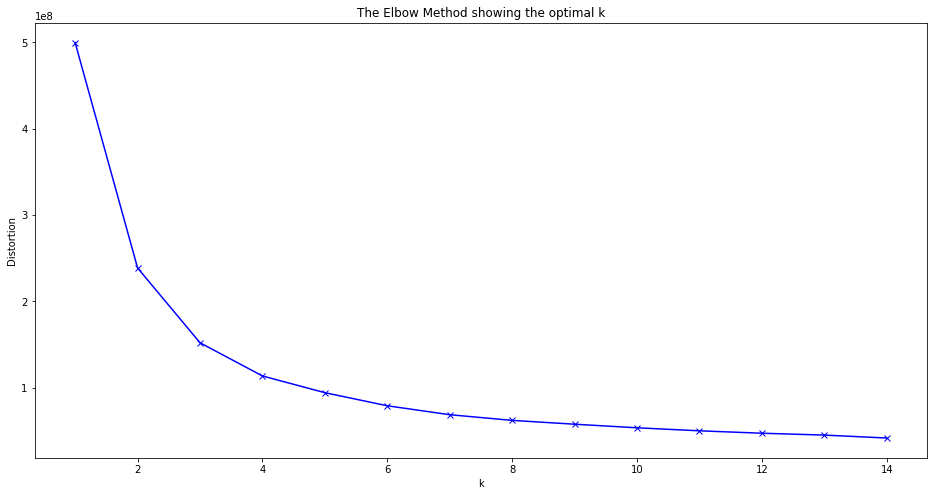

In [104]:
plt.figure(figsize=(16,8))
plt.plot(k_range, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [105]:
scaled_filtered_df.head()

,RAMNTALL,NGIFTALL,AVGGIFT,NUMPROM,NUMPRM12,CARDPROM,CARDPM12,CARDGIFT,MINRAMNT,MAXRAMNT,LASTGIFT,TIMELAG,first_time_delta,minmax_time_delta,maxmin_dollar_diff,SUCCESS_PCT,PCT_TIME_LAPSED_F,PCT_TIME_LAPSED_N,PCT_TIME_LAPSED_A,PCT_TIME_LAPSED_L,PCT_TIME_LAPSED_I,PCT_TIME_LAPSED_S,GIFT_VAR,county_size,WEALTH,INCOME,HOMEOWNR,GENDER_F,GENDER_J,GENDER_M,GENDER_U,CHILDREN,ses,rurality,RECINHSE,RECP3,RECPGVG,RECSWEEP,HIT,MAJOR
0,-0.785408,-0.977794,0.674433,-1.056293,-0.052986,-1.191830,0.416502,-1.075945,0.884241,0.691584,1.036760,1.557883,1.554664,0.064174,0.287016,-1.060719,0.167049,0.819701,0.830304,0.392957,-0.215598,-0.641261,2.914323,-1.064664,1.352407,1.156689,0.629075,-1.082592,-0.068143,1.145826,-0.154886,1.059377,-1.237361,0.153766,-0.298866,-0.152602,-0.024856,-0.138574,0.969771,-0.023392
1,1.009895,1.881465,-0.742657,0.475934,0.167487,0.667072,0.416502,1.775661,-0.878773,-0.273281,-1.268228,0.605372,0.605570,0.577058,0.169314,2.476118,-0.406514,-0.529155,-1.384122,-0.726035,-0.215598,1.901191,-0.377915,0.782187,-1.558164,-0.462807,-1.589636,-1.082592,-0.068143,1.145826,-0.154886,-0.412023,0.141092,-1.364348,-0.298866,-0.152602,-0.024856,-0.138574,-0.272165,-0.023392
2,-0.067287,0.570971,-0.858476,0.624214,0.167487,0.799851,0.416502,0.240181,-0.878773,-0.809318,-0.691981,0.129116,0.125808,-1.588663,-0.419194,0.509779,-0.406514,-0.529155,-0.954658,-0.743350,-0.215598,1.381144,-0.324336,0.782187,-0.466700,-1.542471,-1.589636,0.923709,-0.068143,-0.872733,-0.154886,-0.412023,0.141092,-1.364348,-0.298866,-0.152602,-0.024856,-0.138574,-0.272165,-0.023392
3,1.612191,3.072823,-0.849411,2.947268,2.592689,2.924310,4.062465,0.459535,-0.658396,-0.380488,-0.115734,0.922876,0.928888,0.035160,-0.066089,1.407763,-0.406514,-0.529155,-0.443481,-0.045074,1.148497,-0.641261,0.021057,-1.064664,-1.194343,-0.462807,0.629075,0.923709,-0.068143,-0.872733,-0.154886,1.059377,0.141092,0.153766,3.345978,6.553004,-0.024856,-0.138574,4.873001,-0.023392
4,-0.090452,0.332700,-0.714718,0.475934,-0.934877,0.667072,-1.406479,0.459535,-0.658396,-0.702110,-0.576732,-0.664644,-0.672057,-1.731858,-0.419194,0.296378,-0.406514,-0.529155,-0.484292,-0.726035,-0.215598,0.912460,-0.461154,1.705613,0.260942,0.077025,0.629075,0.923709,-0.068143,-0.872733,-0.154886,1.059377,0.141092,-0.605291,-0.298866,-0.152602,-0.024856,-0.138574,-0.449585,-0.023392


In [106]:
from sklearn.manifold import TSNE

X = scaled_filtered_df

X_embedded = TSNE(
    n_components=2, 
    perplexity=35,
    n_jobs=-1
).fit_transform(X)

In [107]:
X_embedded
x = X_embedded[:,0]
y = X_embedded[:,1]

In [108]:
grid_plot_test = filtered_df.columns.values
len(grid_plot_test)

32

In [109]:
def plotGrid(x, y, dataframe, hue, dimensions, export_path):

    fig, axs = plt.subplots(dimensions[0], dimensions[1], figsize=(25,25))

    for ax_y in range(0, dimensions[0]):
        for ax_x in range(0, dimensions[1]):
            idx = (ax_y * dimensions[0]) + ax_x

            if(idx >= len(hue)):
                axs[ax_y, ax_x].axis('off')
            
            else:
                print('plot %d: %s' % (idx, hue[idx]))

                col = dataframe[hue[idx]]

                axs[ax_y, ax_x].set_title(hue[idx])
                sns.scatterplot(x=x, y=y, hue=col, ax=axs[ax_y, ax_x])

    plt.savefig(export_path)
    plt.close(fig)

In [110]:
plotGrid(
    x=x, 
    y=y, 
    dataframe=filtered_df, 
    hue=grid_plot_test[0:9], 
    dimensions=(3,3), 
    export_path='Images/GridPlot/0_8.png'
)

plot 0: RAMNTALL
plot 1: AVGGIFT
plot 2: NUMPROM
plot 3: NUMPRM12
plot 4: CARDPM12
plot 5: MINRAMNT
plot 6: TIMELAG
plot 7: maxmin_dollar_diff
plot 8: SUCCESS_PCT


In [111]:
plotGrid(
    x=x, 
    y=y, 
    dataframe=filtered_df, 
    hue=grid_plot_test[9:18], 
    dimensions=(3,3), 
    export_path='Images/GridPlot/9_17.png'
)

plot 0: PCT_TIME_LAPSED_F
plot 1: PCT_TIME_LAPSED_N
plot 2: PCT_TIME_LAPSED_A
plot 3: PCT_TIME_LAPSED_L
plot 4: PCT_TIME_LAPSED_I
plot 5: PCT_TIME_LAPSED_S
plot 6: GIFT_VAR
plot 7: WEALTH
plot 8: INCOME


In [112]:
plotGrid(
    x=x, 
    y=y, 
    dataframe=filtered_df, 
    hue=grid_plot_test[18:27], 
    dimensions=(3,3), 
    export_path='Images/GridPlot/18_26.png'
)

plot 0: HOMEOWNR
plot 1: GENDER_F
plot 2: GENDER_J
plot 3: GENDER_M
plot 4: GENDER_U
plot 5: CHILDREN
plot 6: ses
plot 7: rurality
plot 8: RECINHSE


In [113]:
plotGrid(
    x=x, 
    y=y, 
    dataframe=filtered_df, 
    hue=grid_plot_test[27:36], 
    dimensions=(3,3), 
    export_path='Images/GridPlot/26_35.png'
)

plot 0: RECP3
plot 1: RECPGVG
plot 2: RECSWEEP
plot 3: HIT
plot 4: MAJOR


<img style="background-color: white" src="Images\GridPlot\0_8.png"/>

<img style="background-color: white" src="Images\GridPlot\9_17.png"/>

<img style="background-color: white" src="Images/GridPlot/18_26.png"/>

<img style="background-color: white" src="Images/GridPlot/26_35.png"/>

In [ ]:
z = len(filtered_df.columns)

In [ ]:
import matplotlib.pyplot as plt 

In [ ]:
for column in filtered_df.columns: 
    plt.figure(figsize=(20,20))
    sns.scatterplot(x,y, hue = filtered_df[column])
    plt.savefig('Images/%s_TSNE.png' % column)

In [ ]:
from sklearn.manifold import TSNE

X = scaled_filtered_df

X_embedded3 = TSNE(n_components=3).fit_transform(X)


In [ ]:
df1 = pd.DataFrame(X_embedded3, columns = ['0','1','2'])
df1['MAJOR'] = filtered_df['MAJOR']

In [ ]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default='notebook'
#df = px.data.iris()
fig = px.scatter_3d(df1, x='0', y='1', z='2',
              color='MAJOR')
fig.show()

In [ ]:
from sklearn.feature_selection import VarianceThreshold

k_means = KMeans(n_clusters=3)
k_means.fit(filtered_df)

new_column = 'cluster'

selector = VarianceThreshold()

filtered_df[new_column] = k_means.predict(selector.fit_transform(filtered_df))


selector

In [ ]:
selector.get_support()

In [ ]:
filtered_df.head()

In [ ]:
filtered_df.groupby(new_column).mean().transpose()

In [ ]:
pctimes = ['PCT_TIME_LAPSED_F', 'PCT_TIME_LAPSED_N', 'PCT_TIME_LAPSED_L', 'PCT_TIME_LAPSED_S', 'PCT_TIME_LAPSED_A', 'PCT_TIME_LAPSED_I']
target =  ['AVGGIFT', 'SUCCESS_PCT']
total = pctimes+target

In [ ]:
model = KMeans(n_clusters=3)

new_column = 'cluster_affinity'

#selector = VarianceThreshold()

filtered_df[new_column] = model.fit_predict(filtered_df[total])


#filtered_df[new_column] = model.fit_predict(selector.fit_transform(filtered_df.iloc[:,:-1]))


selector.get_support()

In [ ]:
filtered_df['cluster_affinity'].value_counts()

In [ ]:
filtered_df.iloc[:,:-2]

In [ ]:
filtered_df.isna().sum()

In [ ]:
X_embedded

In [ ]:
len(pd.Series(model.labels_).unique())

In [ ]:
figure = boxplot_cluster_compparisson(filtered_df)

In [ ]:
figure.savefig('Images/pretty_boxplot.png')